`python3 -m pip install -U pandas plotly nbformat networkx`
# Extract, Transform, Load

Before you can run this notebook, make sure you have Python 3.10 installed and execute `pip install -r requirements.txt`.

In [1]:
%reload_ext autoreload
%autoreload 2
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wavescapes

import etl
import utils

Configuring the notebook to produce the defaults from the paper. For more information on available normalization methods (variable `how` below) see the section "Loading magnitude-phase matrices" below.

In [2]:
DEBUSSY_REPO = '..'
DATA_FOLDER = 'pickled_magnitude_phase_matrices'
os.makedirs(DATA_FOLDER, exist_ok=True)
DEFAULT_FIGURE_SIZE = 1000 #2286
EXAMPLE_FNAME = 'l123-08_preludes_ondine'
how = '0c'
indulge = True
norm_method = (how, indulge)

## Loading metadata
Metadata for all pieces contained in the dataset.

In [3]:
metadata = etl.get_metadata(DEBUSSY_REPO)
metadata.head()

Metadata for 82 files.


corpus  \
fname                                                     
l000_etude                   debussy_other_piano_pieces   
l000_soirs                   debussy_other_piano_pieces   
l009_danse                   debussy_other_piano_pieces   
l066-01_arabesques_premiere     debussy_deux_arabesques   
l066-02_arabesques_deuxieme     debussy_deux_arabesques   

                                              TimeSig  \
fname                                                   
l000_etude                                     1: 4/4   
l000_soirs                                     1: 4/4   
l009_danse                                     1: 2/4   
l066-01_arabesques_premiere  1: 4/4, 94: 2/4, 95: 4/4   
l066-02_arabesques_deuxieme                    1: 4/4   

                                                                        KeySig  \
fname                                                                            
l000_etude                   1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...   
l000_soirs                                                               1: -4   
l009_danse                                                  1: 2, 45: 5, 61: 2   
l066-01_arabesques_premiere                                 1: 4, 39: 3, 71: 4   
l066-02_arabesques_deuxieme                                               1: 1   

                             last_mc  last_mn  length_qb  last_mc_unfolded  \
fname                                                                        
l000_etude                        73       71      284.0                73   
l000_soirs                        23       23       92.0                23   
l009_danse                        92       92      184.0                92   
l066-01_arabesques_premiere      107      107      426.0               107   
l066-02_arabesques_deuxieme      110      110      440.0               110   

                             last_mn_unfolded  length_qb_unfolded  \
fname                                                               
l000_etude                                 71               284.0   
l000_soirs                                 23                92.0   
l009_danse                                 92               184.0   
l066-01_arabesques_premiere               107               426.0   
l066-02_arabesques_deuxieme               110               440.0   

                             all_notes_qb  ...  composed_source  imslp  viaf  \
fname                                      ...                                 
l000_etude                         959.25  ...              NaN    NaN   NaN   
l000_soirs                         528.00  ...              NaN    NaN   NaN   
l009_danse                         586.50  ...              NaN    NaN   NaN   
l066-01_arabesques_premiere       1207.83  ...              NaN    NaN   NaN   
l066-02_arabesques_deuxieme       1222.00  ...              NaN    NaN   NaN   

                             musicbrainz  wikidata    year  median_recording  \
fname                                                                          
l000_etude                           NaN       NaN  1915.0          272.5530   
l000_soirs                           NaN       NaN  1917.0          145.8265   
l009_danse                           NaN       NaN  1880.0          124.5995   
l066-01_arabesques_premiere          NaN       NaN  1888.0          240.7780   
l066-02_arabesques_deuxieme          NaN       NaN  1891.0          213.9330   

                            qb_per_minute sounding_notes_per_qb  \
fname                                                             
l000_etude                      62.519950              3.377641   
l000_soirs                      37.853202              5.739130   
l009_danse                      88.603887              3.187500   
l066-01_arabesques_premiere    106.155878              2.835282   
l066-02_arabesques_deuxieme    123.403122              2.777273   

                            sounding_

### Columns for ordinal plots

Creating a column years_ordinal that represents the year of publication as a range of years in which Debussy composed.

Also creating a column years_periods in which the years of publication are grouped into three periods.

Periods:

* 1880-1892
* 1893-1912
* 1913-1917

src: the cambridge companion to Debussy (the phases years are not consistent accross all sources)


In [4]:
years_ordinal = {val:idx for idx, val in enumerate(np.sort(metadata.year.unique()))}
metadata['years_ordinal'] = metadata.year.apply(lambda x: years_ordinal[x])

In [5]:
years_periods = {}

for idx, val in enumerate(np.sort(metadata.year.unique())):
    if val < 1893:
        years_periods[val] = 0
    elif val < 1913:
        years_periods[val] = 1
    else:
        years_periods[val] = 2

metadata['years_periods'] = metadata.year.fillna(1880.0).apply(lambda x: years_periods[x])
metadata.years_ordinal.head(1),metadata.years_periods.head(1) 

(fname
 l000_etude    18
 Name: years_ordinal, dtype: int64,
 fname
 l000_etude    2
 Name: years_periods, dtype: int64)

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [6]:
pcvs = etl.get_pcvs(DEBUSSY_REPO, pandas=True)
etl.test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Found matrices for all files listed in metadata.tsv.


0    1    2    3    4    5    6    7    8    9   10   11
interval                                                              
[0.0, 1.0)  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.5  0.0
[1.0, 2.0)  0.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
[2.0, 3.0)  0.0  1.5  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.5  0.0
[3.0, 4.0)  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.0  0.5
[4.0, 5.0)  0.0  2.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0

## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included).

The following example shows the upper left 3x3 submatrix where
* the first three entries (which are PCVs of size 12) correspond to the pitch class distributions of the piece's first three quarternote slices,
* the two last vectors of the second row each correspond to a sum of two adjacent vectors above, and
* the last entry of the the third row corresponds to the sum all three PCVs.

In [7]:
pcms = etl.get_pcms(DEBUSSY_REPO)
etl.test_dict_keys(pcms, metadata)
print(f"Shape of the PCM for {EXAMPLE_FNAME}: {pcms[EXAMPLE_FNAME].shape}")
pcms[EXAMPLE_FNAME][:3, :3]

Found matrices for all files listed in metadata.tsv.
Shape of the PCM for l123-08_preludes_ondine: (224, 224, 12)


array([[[0. , 1. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0.5, 0. ],
        [0. , 2. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 1.5, 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0.5, 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 3. , 0. , 0. , 0. , 1. , 0. , 0.5, 0. , 0.5, 0.5, 0. ],
        [0. , 3.5, 0. , 0. , 0. , 1. , 0. , 0.5, 0. , 0.5, 0.5, 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 4.5, 0. , 0. , 0. , 1. , 0. , 1. , 0. , 1. , 1. , 0. ]]])

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [8]:
dfts = etl.get_dfts(DEBUSSY_REPO)
etl.test_dict_keys(dfts, metadata)
print(f"Shape of the DFT for {EXAMPLE_FNAME}: {dfts[EXAMPLE_FNAME].shape}")
dfts[EXAMPLE_FNAME][0,0]

Found matrices for all files listed in metadata.tsv.
Shape of the DFT for l123-08_preludes_ondine: (224, 224, 7)


array([ 2.50000000e+00+0.00000000e+00j,  6.83012702e-01+6.83012702e-01j,
       -5.55111512e-17-8.66025404e-01j, -5.00000000e-01-1.00000000e+00j,
       -5.00000000e-01-1.73205081e+00j, -1.83012702e-01-1.83012702e-01j,
       -1.50000000e+00+5.55111512e-17j])

You can view the 7 complex numbers as magnitude-phase pairs. In the following we use magnitude-phase-matrices of this format.

In [9]:
utils.get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.5+0°'],
       ['0.97+315°'],
       ['0.87+90°'],
       ['1.12+117°'],
       ['1.8+106°'],
       ['0.26+135°'],
       ['1.5+180°']], dtype='<U9')

For convenience, values can also be inspected as strings where the numbers are rounded and angles are shown in degrees:

In [10]:
utils.get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.5+0°'],
       ['0.97+315°'],
       ['0.87+90°'],
       ['1.12+117°'],
       ['1.8+106°'],
       ['0.26+135°'],
       ['1.5+180°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The first time the notebook runs, the matrices are computed and pickled to disk, from where they can be loaded on later runs.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

### Normalizing magnitudes

The available normalization methods for `how` are:
* **'0c'** default normalisation, will normalise each magnitude by the 0th coefficient (which corresponds to the sum of the weight of each pitch class). This ensures onlypitch class distribution whose periodicity exactly match the coefficient's periodicity can reach the value of 1.
* **'post_norm'** based on the 0c normalisation but "boost" the space of all normalized magnitude so the maximum magnitude observable is set to the max opacity value. This means that if any PCV in the utm given as input reaches the 0c normalized magnitude of 1, this parameter acts like the '0c' one. This magn_strat should be used with audio input mainly, as seldom PCV derived from audio data can reach the maximal value of normalized magnitude for any coefficient.
* **'max'** set the grayscal value 1 to the maximum possible magnitude in the wavescape, and interpolate linearly all other values of magnitude based on that maximum value set to 1. Warning: will bias the visual representation in a way that the top of the visualisation will display much more magnitude than lower levels.
* **'max_weighted'** same principle as max, except the maximum magnitude is now taken at the hierarchical level, in other words, each level will have a different opacity mapping, with the value 1 set to the maximum magnitude t this level. This normalisation is an attempt to remove the bias toward higher hierarchical level that is introduced by the 'max' magnitude process cited previously.

`indulge` is an additional normalization that we apply to the magnitude based on the phase. Since magnitudes of 1 are possible only for a prototypical phase sitting on the unit circle, you can set this parameter to True to normalize the magnitudes by the maximally achievable magnitude given the phase which is bounded by straight lines between adjacent prototypes. (Musical prototypes are visualized in the [midiVERTO webApp](https://dcmlab.github.io/midiVERTO/#/analysis)) The pitch class vectors that benefit most from this normalization in terms of magnitude gain are those whose phase is exactly between two prototypes, such as the "octatonic" combination O₀,₁. The maximal "boosting" factors for the first 5 coefficients are `{1: 1.035276, 2: 1.15470, 3: 1.30656, 4: 2.0, 5: 1.035276}`. The sixth coefficient's phase can only be 0 or pi so it remains unchanged. Use this option if you want to compensate for the smaller magnitude space of the middle coefficients.

In [11]:
mag_phase_mx_dict = etl.get_magnitude_phase_matrices(dfts=dfts, data_folder=DATA_FOLDER, norm_params=norm_method)
etl.test_dict_keys(mag_phase_mx_dict, metadata)
print(f"Shape of the magnitude-phase matrix for {EXAMPLE_FNAME}: {mag_phase_mx_dict[EXAMPLE_FNAME].shape}")

Checking for existing files to be skipped... DONE
No new magnitude-phase matrices to be computed.
Found matrices for all files listed in metadata.tsv.
Shape of the magnitude-phase matrix for l123-08_preludes_ondine: (224, 224, 6, 2)


## Summary wavescapes

This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

The following example shows these 3 values for the bottom row of the example summary wavescape.

In [12]:
max_coeffs, max_mags, inv_entropies = etl.get_most_resonant(mag_phase_mx_dict)
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

array([[3.        , 2.        , 3.        , ..., 0.22767643, 0.22767643,
        0.22767643],
       [0.        , 2.        , 2.        , ..., 0.22767643, 0.22767643,
        0.22767643],
       [0.        , 0.        , 2.        , ..., 0.22767643, 0.22767643,
        0.22767643]])

## Loading major, minor, and tritone correlations

This cell loads pickled matrices. To re-compute correlations from pitch-class matrices, use `get_maj_min_coeffs()` for major and minor correlations and `get_ttms()` for tritone-ness matrices.

In [13]:
LONG_FORMAT = False

correl_dict = etl.get_correlations(DEBUSSY_REPO, DATA_FOLDER, long=LONG_FORMAT)
etl.test_dict_keys(correl_dict, metadata)
correl_dict[EXAMPLE_FNAME].shape

Computing pitch-class-vector triangles... DONE
No new correlation matrices to be computed.
Found matrices for all files listed in metadata.tsv.


(224, 224, 3)

## Loading pickled 9-fold vectors

The function is a shortcut for
* loading a particular kind of pickled normalized magnitude-phase-matrices
* loading pickled tritone, major, and minor coefficients
* concatenating them toegther

In [14]:
norm_params = ('0c', True)
ninefold_dict = etl.make_feature_vectors(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
etl.test_dict_keys(ninefold_dict, metadata)
ninefold_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(224, 224, 9)

# Metrics

In this section, a dataframe containing all metrics is compiled. Optional plots and tests can be done by adjusting the parameters of the wrapper function `get_metric` that can be found in `etl.py`. 

In [15]:
metadata_metrics = metadata.copy()
#metadata_metrics = pd.read_csv('metrics.csv').set_index('fname')

## Center of mass

Computing the center of mass of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the vertical center of mass as a fraction of the height of the wavescape.

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.2659783985855332, 0.21163030043079317, 0.24314686530076748, 0.22165289878386507, 0.2852515669910085, 0.21447996960455884]


corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  sounding_notes_per_qb  \
fname                                         ...                          
l000_etude               284.0        959.25  ...               3.377641   

            sounding_notes_per_minute  years_ordinal  years_periods  \
fname                                                                 
l000_etude                 211.169938             18              2   

            center_of_mass_1  center_of_mass_2  center_of_mass_3  \
fname                                                              
l000_etude          0.265978           0.21163          0.243147   

           center_of_mass_4 center_of_mass_5 center_of_mass_6  
fname                                                          
l000_etude         0.221653         0.285252          0.21448  

[1 rows x 78 columns]

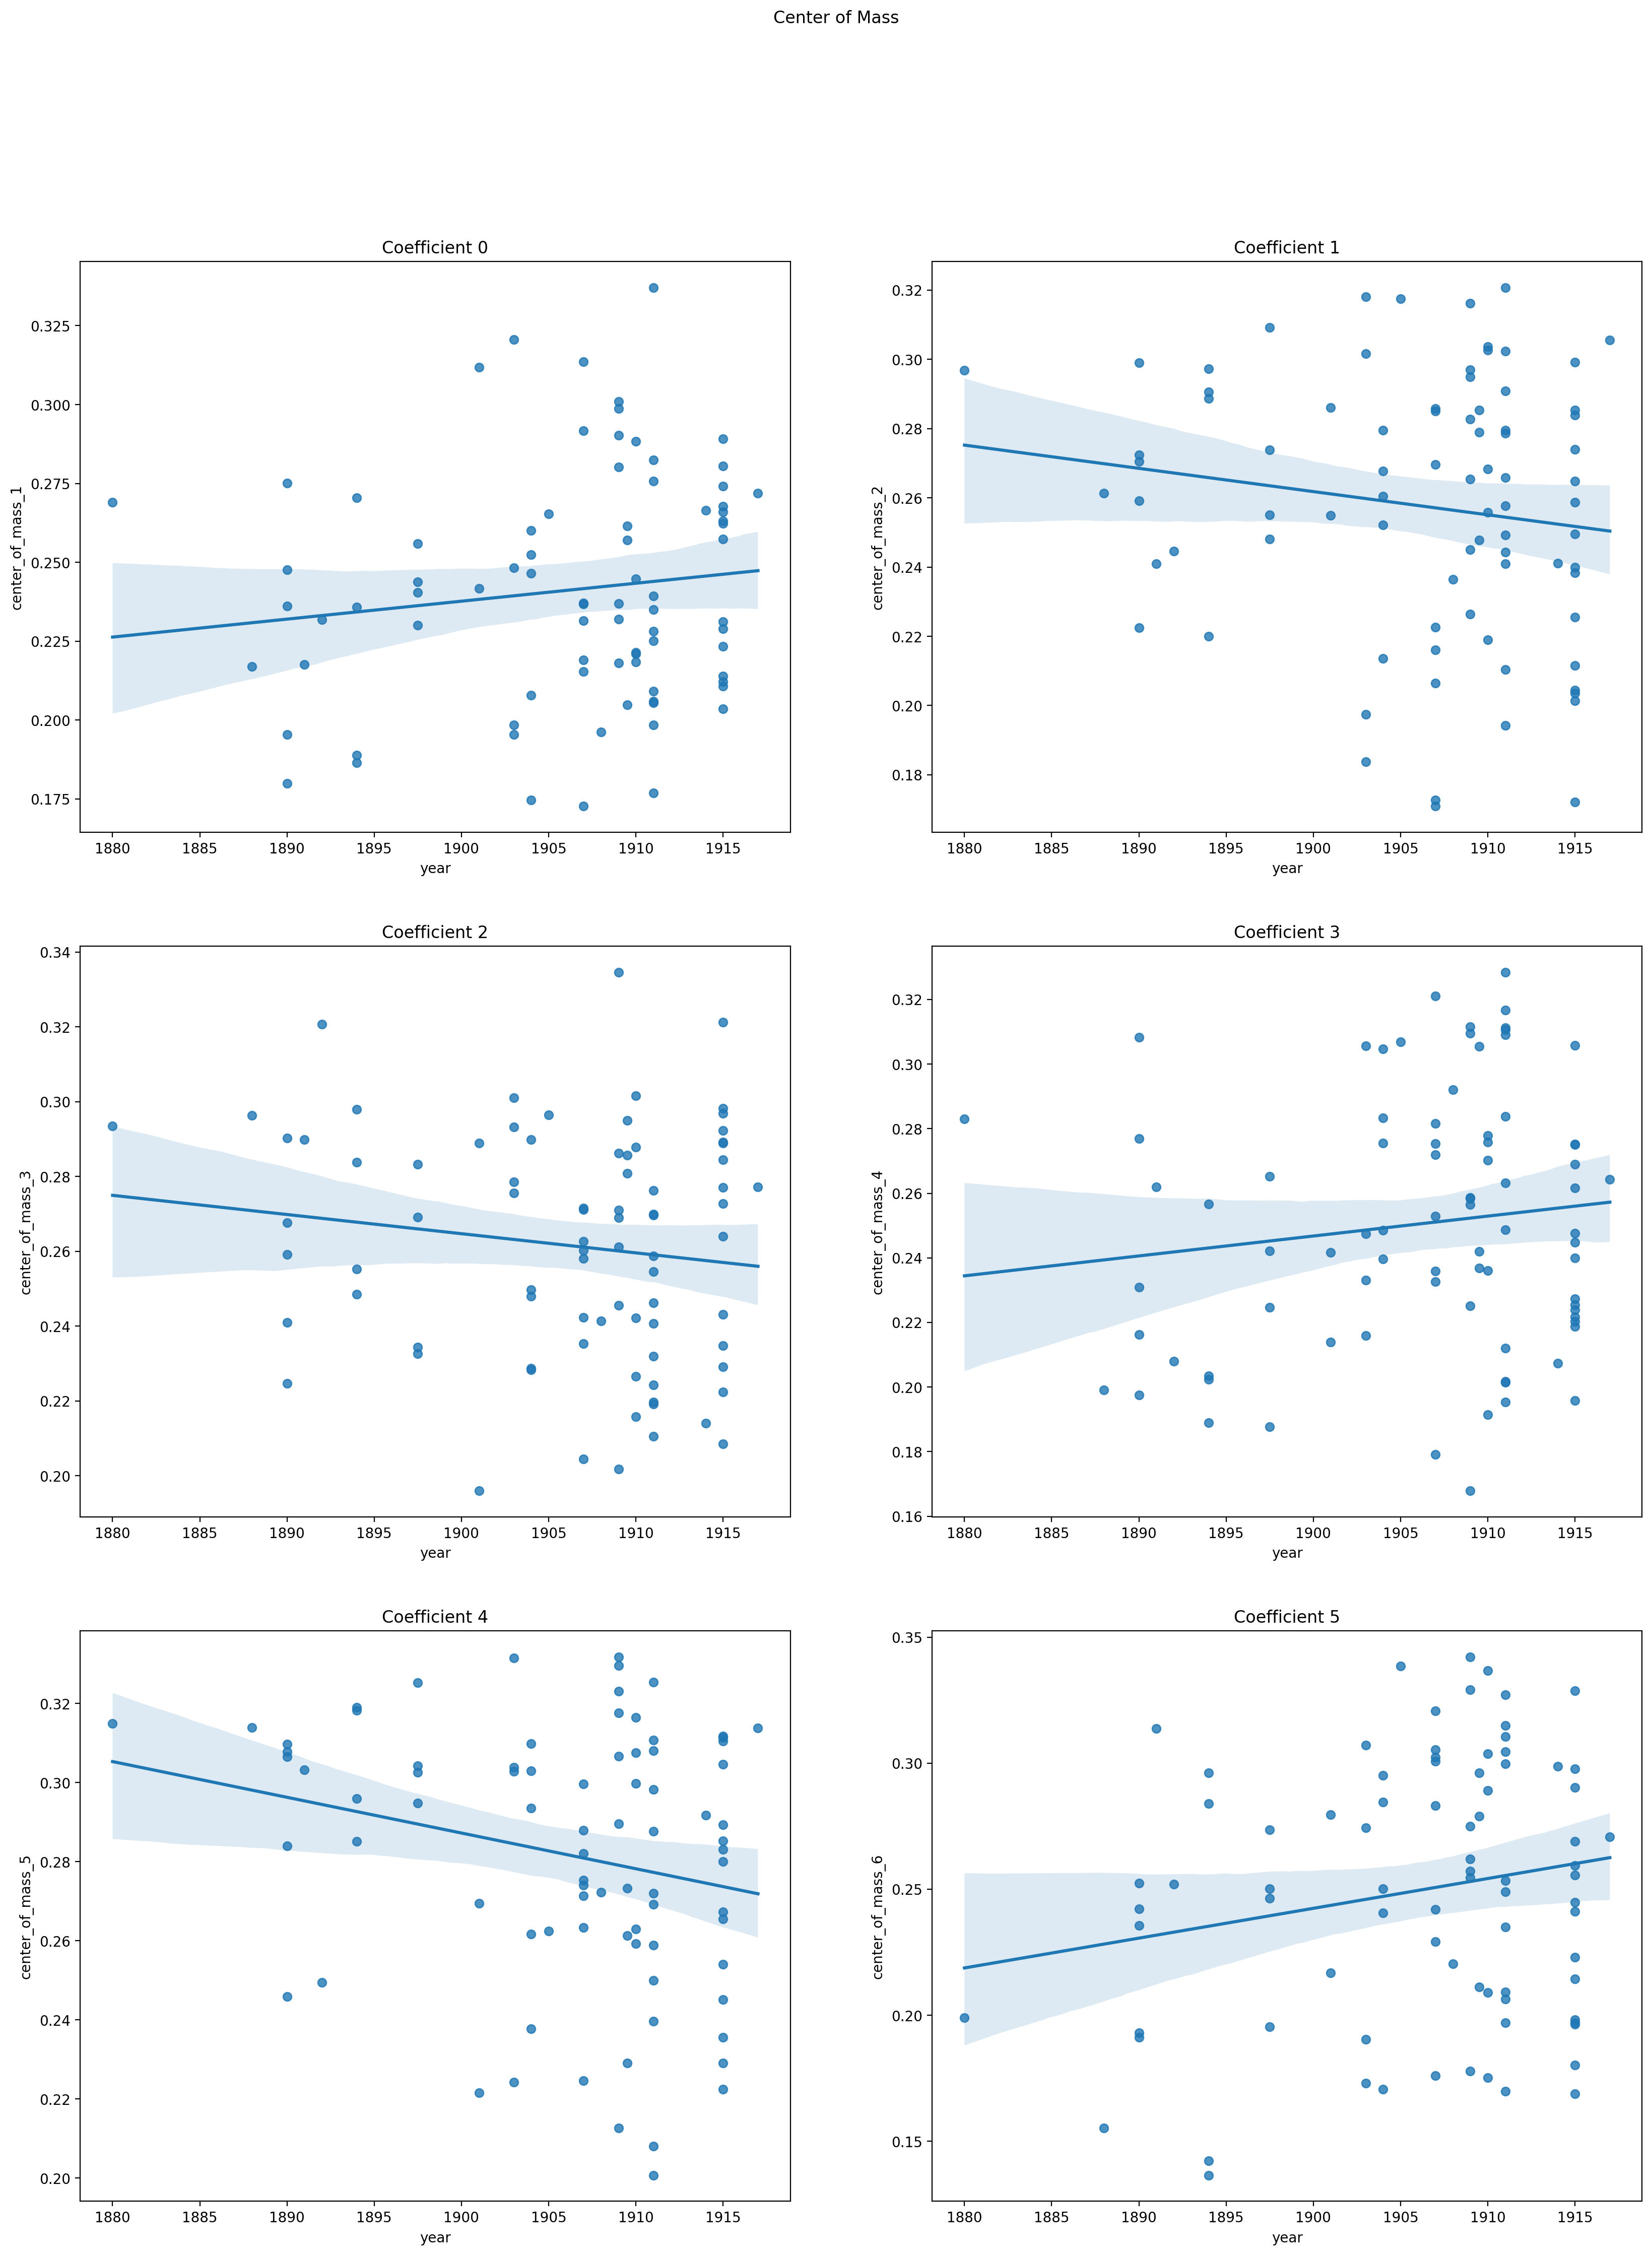

In [16]:
cols = [f"center_of_mass_{i}" for i in range(1,7)]
metadata_metrics = etl.get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict, 
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass')
metadata_metrics.head(1)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.2659783985855332, 0.21163030043079317, 0.24314686530076748, 0.22165289878386507, 0.2852515669910085, 0.21447996960455884]


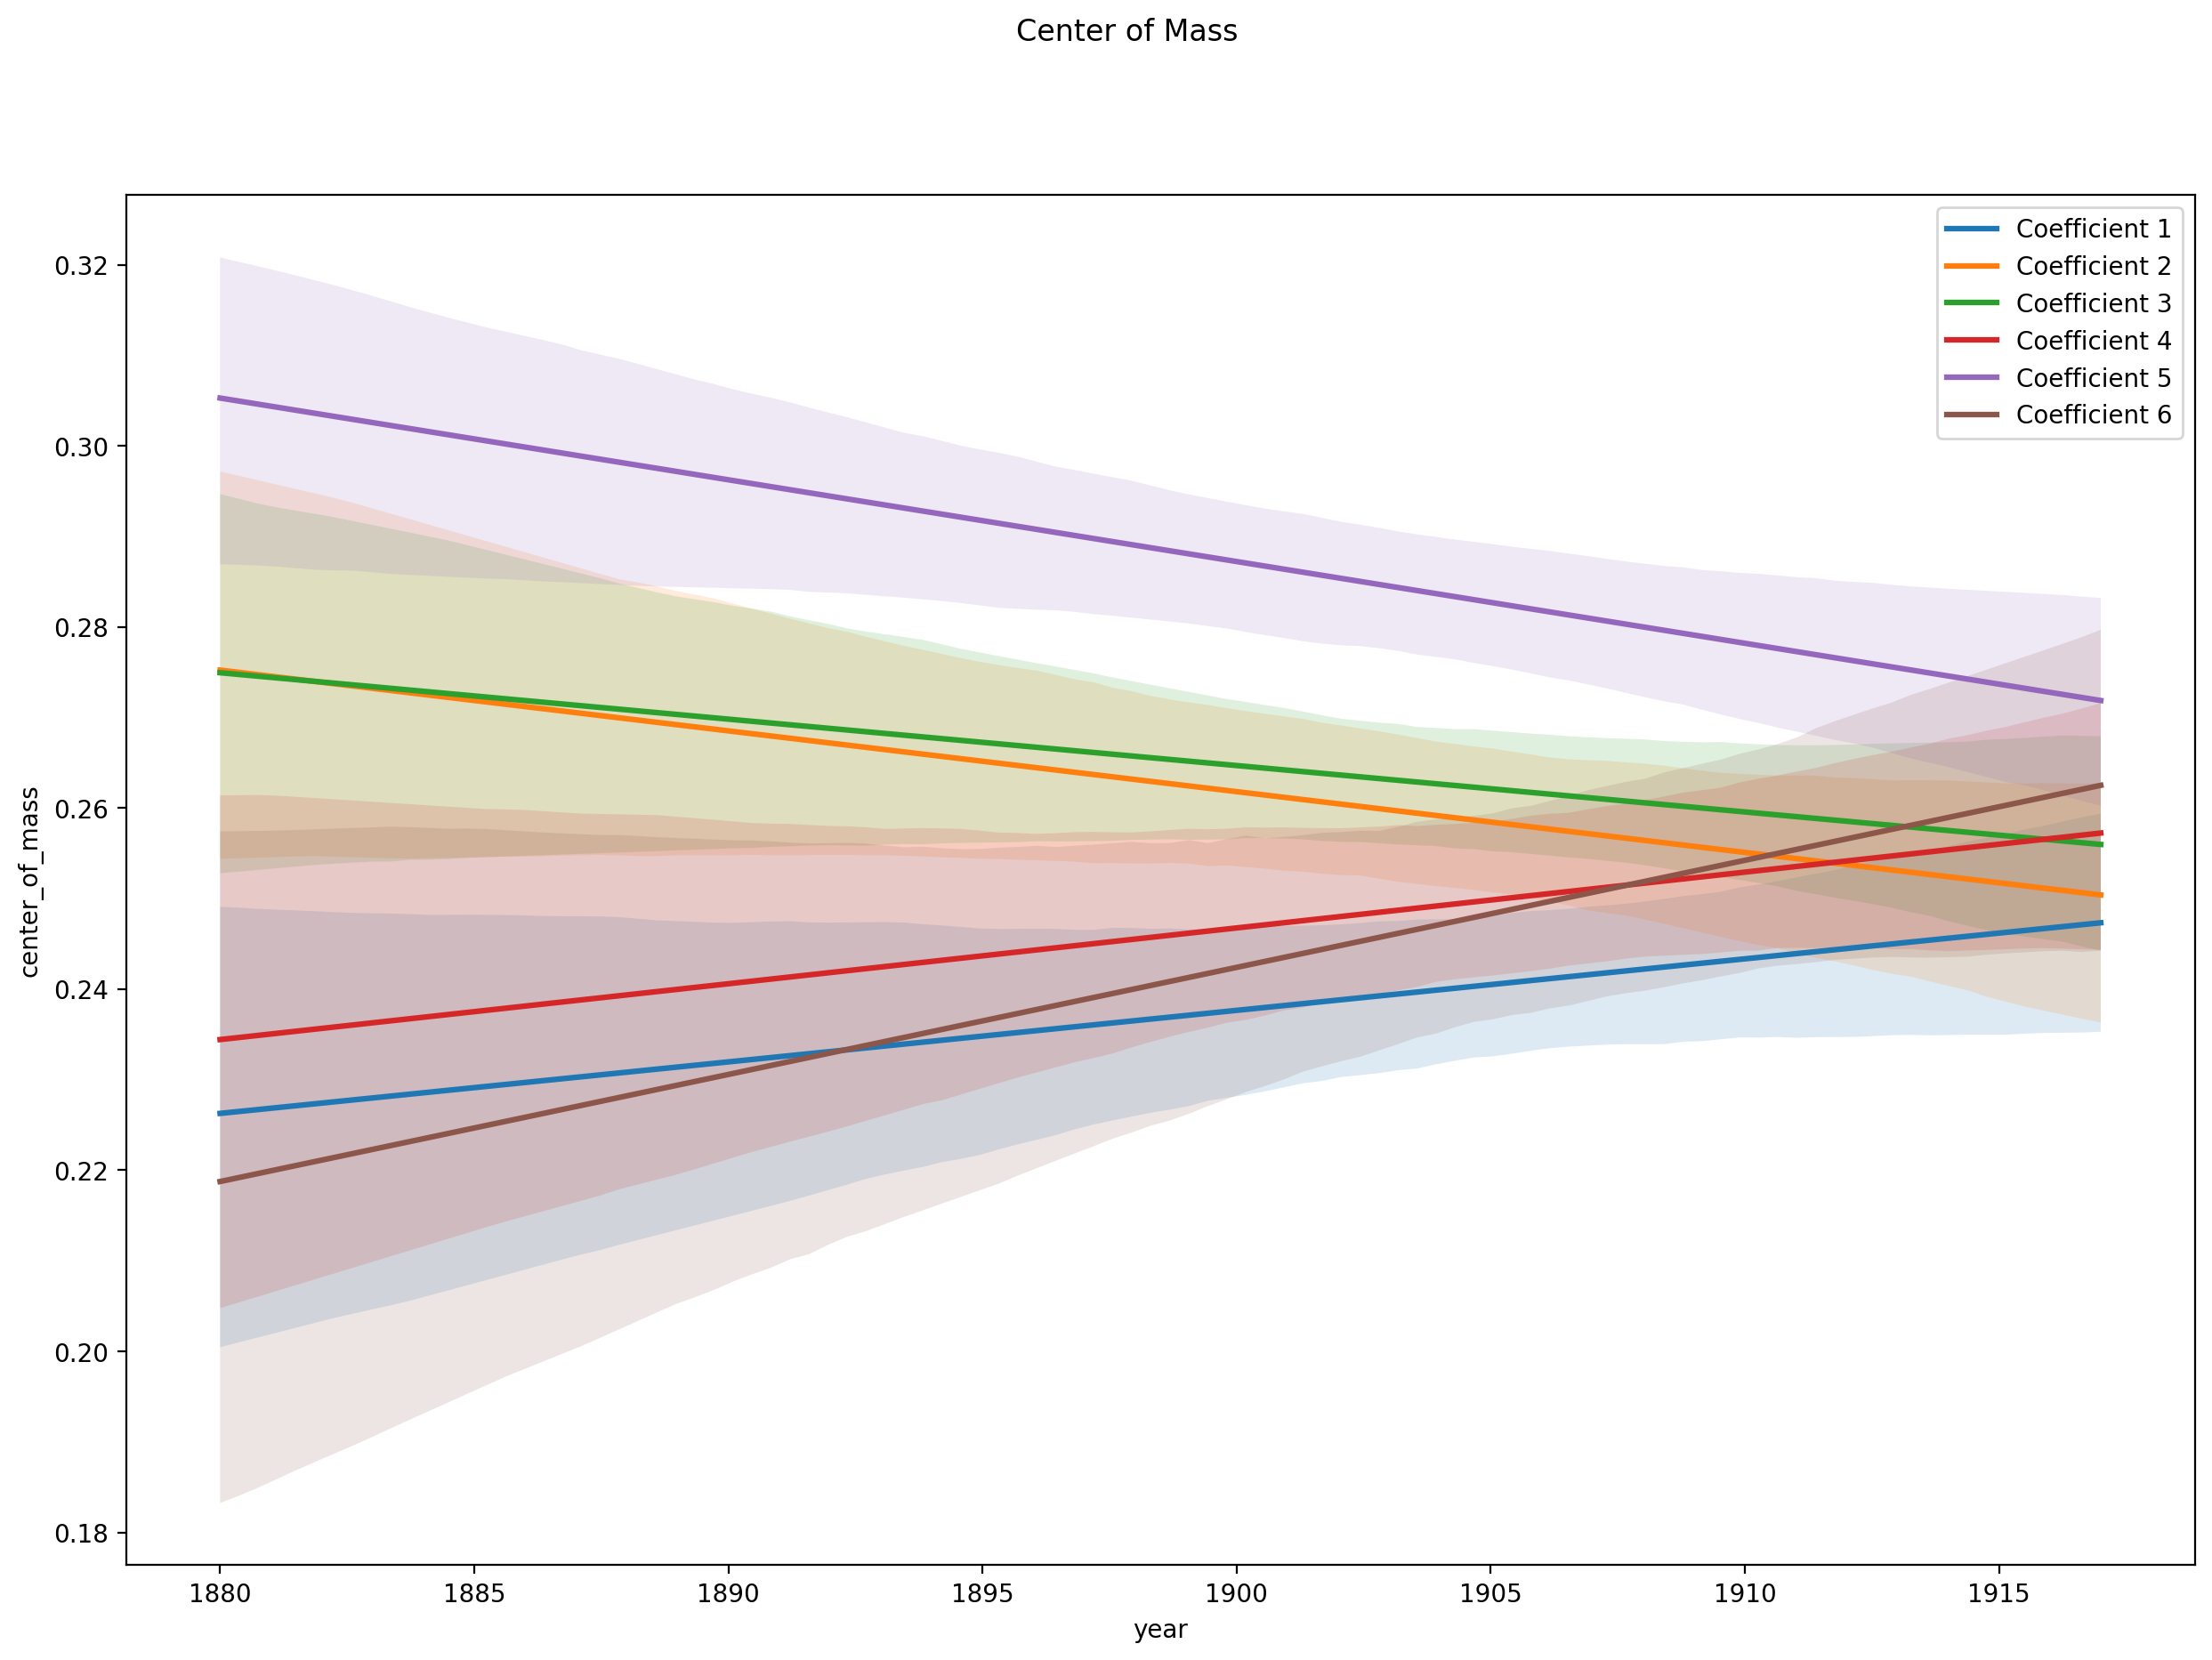

In [17]:
# trying out some options of the function
# 1 unified plot
metadata_metrics = etl.get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass',
                              unified=True)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.2659783985855332, 0.21163030043079317, 0.24314686530076748, 0.22165289878386507, 0.2852515669910085, 0.21447996960455884]


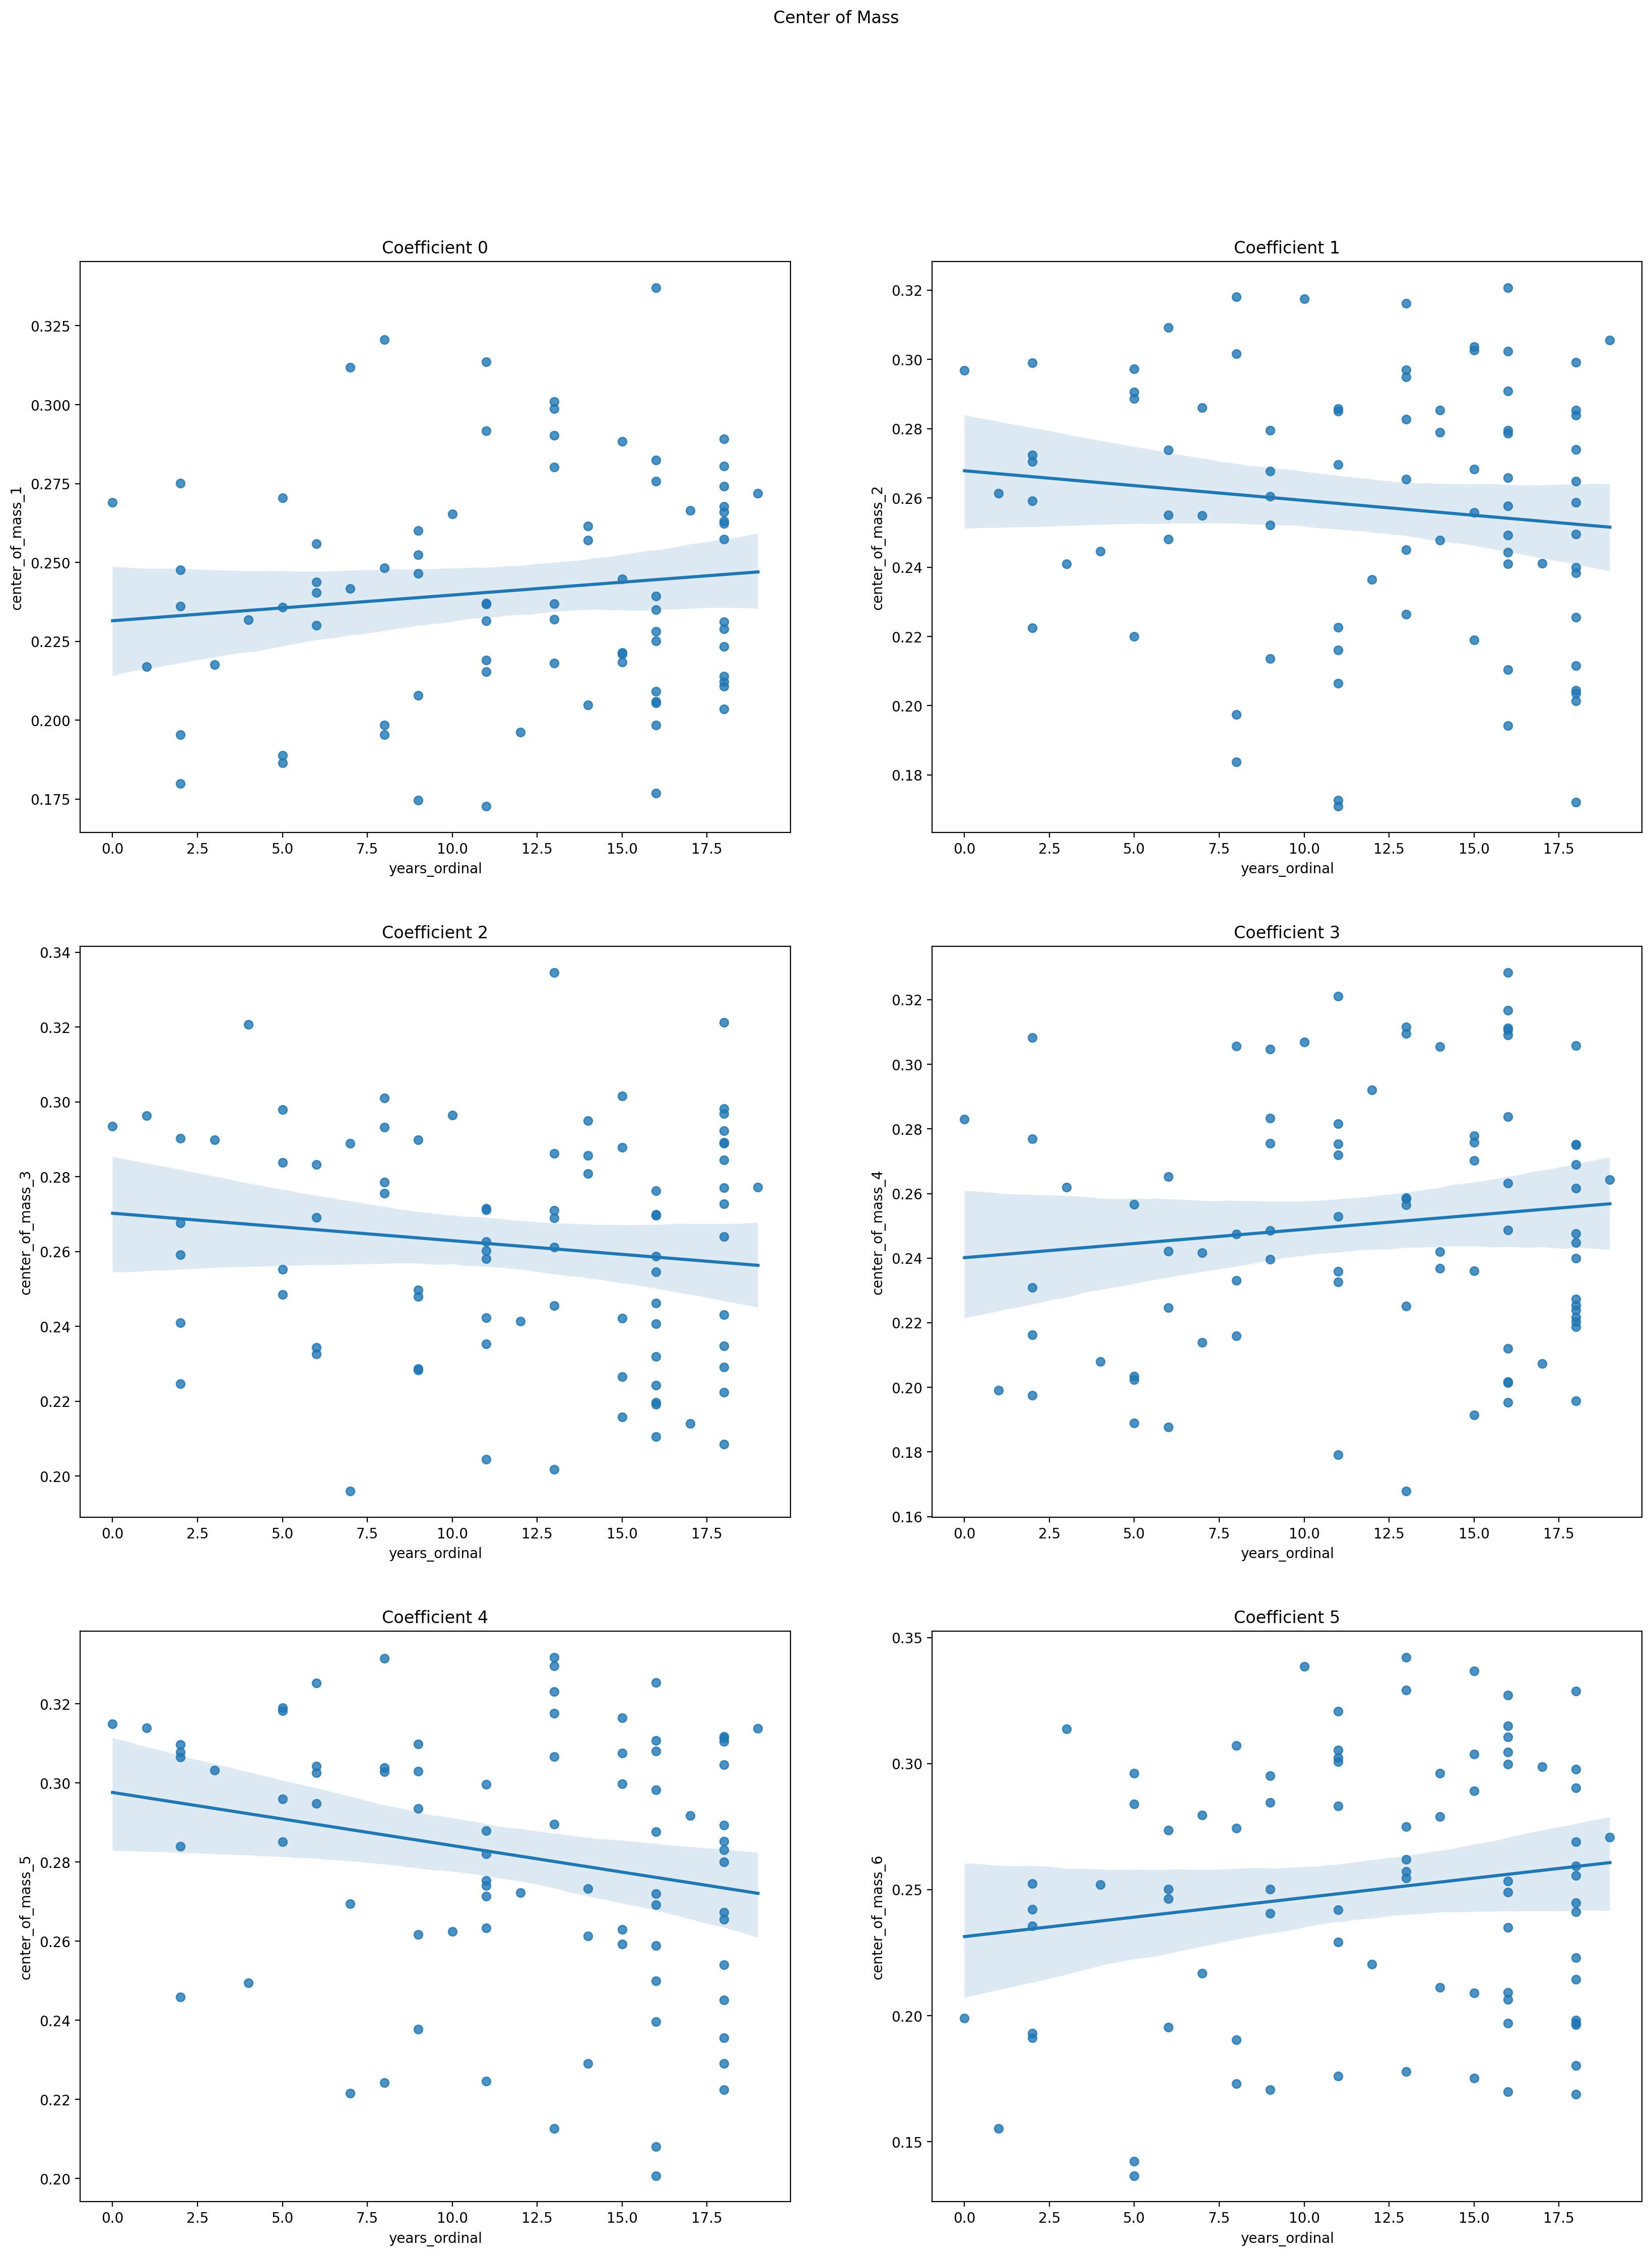

In [18]:
# 2 using ordinal years
metadata_metrics = etl.get_metric('center_of_mass', metadata_metrics,
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True,
                              show_plot=True, save_name='center_of_mass', title='Center of Mass',
                              ordinal=True, ordinal_col='years_ordinal')

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.2659783985855332, 0.21163030043079317, 0.24314686530076748, 0.22165289878386507, 0.2852515669910085, 0.21447996960455884]


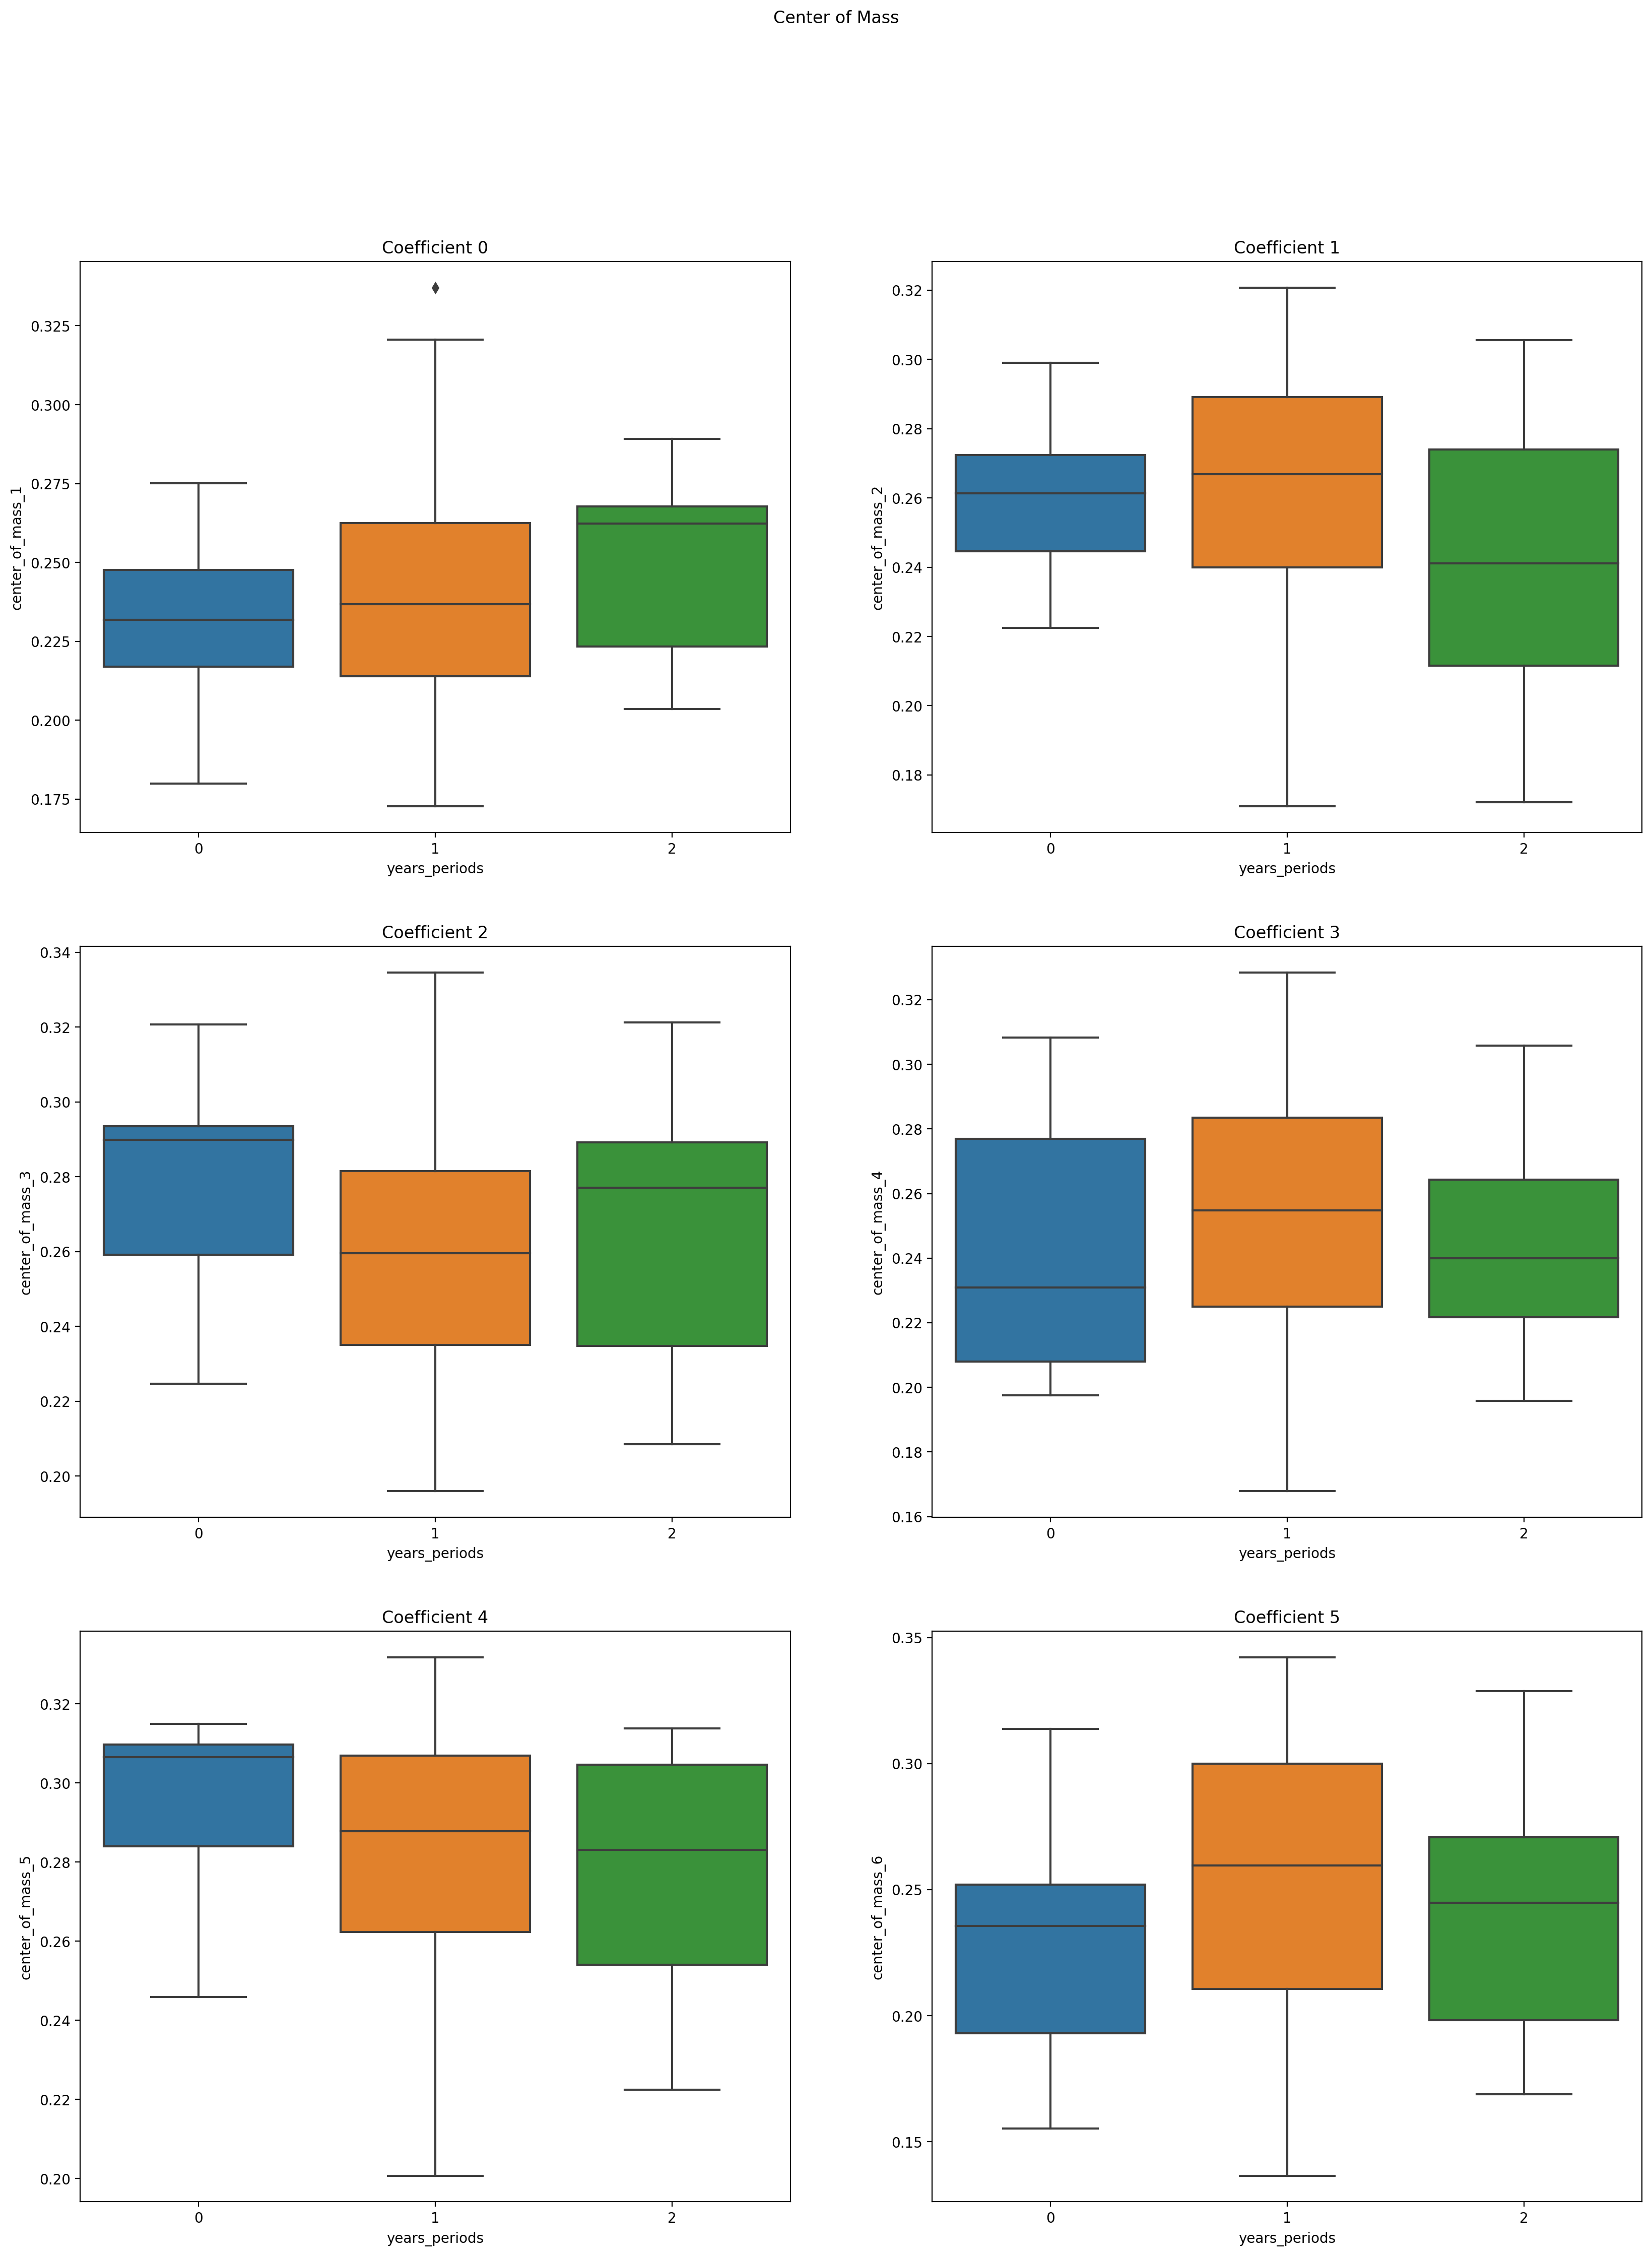

In [19]:
# boxplot version with ordinal column
metadata_metrics = etl.get_metric('center_of_mass', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='center_of_mass', title='Center of Mass', 
                              boxplot=True, ordinal=True, ordinal_col='years_periods')

In [20]:
# 4. testing option
metadata_metrics = etl.get_metric('center_of_mass', metadata_metrics,
                              mag_phase_mx_dict=mag_phase_mx_dict, cols=cols,
                              store_matrix=True, testing=True)

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.2659783985855332, 0.21163030043079317, 0.24314686530076748, 0.22165289878386507, 0.2852515669910085, 0.21447996960455884]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.721
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           2.94e-09
Time:                        21:04:12   Log-Likelihood:                 911.79
No. Observations:                 492   AIC:                            -1798.
Df Residuals:                     479   BIC:                            -1743.
Df Model:                          12                                         
Covariance Type:            nonrobus

# Mean Resonance

Computing the mean resonance of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the magnitude resonance of the wavescape for each coefficient.

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.05351475 0.06532752 0.10387982 0.15190818 0.15171844 0.06171801]


corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  center_of_mass_3  \
fname                                         ...                     
l000_etude               284.0        959.25  ...          0.243147   

            center_of_mass_4  center_of_mass_5  center_of_mass_6  \
fname                                                              
l000_etude          0.221653          0.285252           0.21448   

            mean_resonances_1  mean_resonances_2  mean_resonances_3  \
fname                                                                 
l000_etude           0.053515           0.065328            0.10388   

           mean_resonances_4 mean_resonances_5 mean_resonances_6  
fname                                                             
l000_etude          0.151908          0.151718          0.061718  

[1 rows x 84 columns]

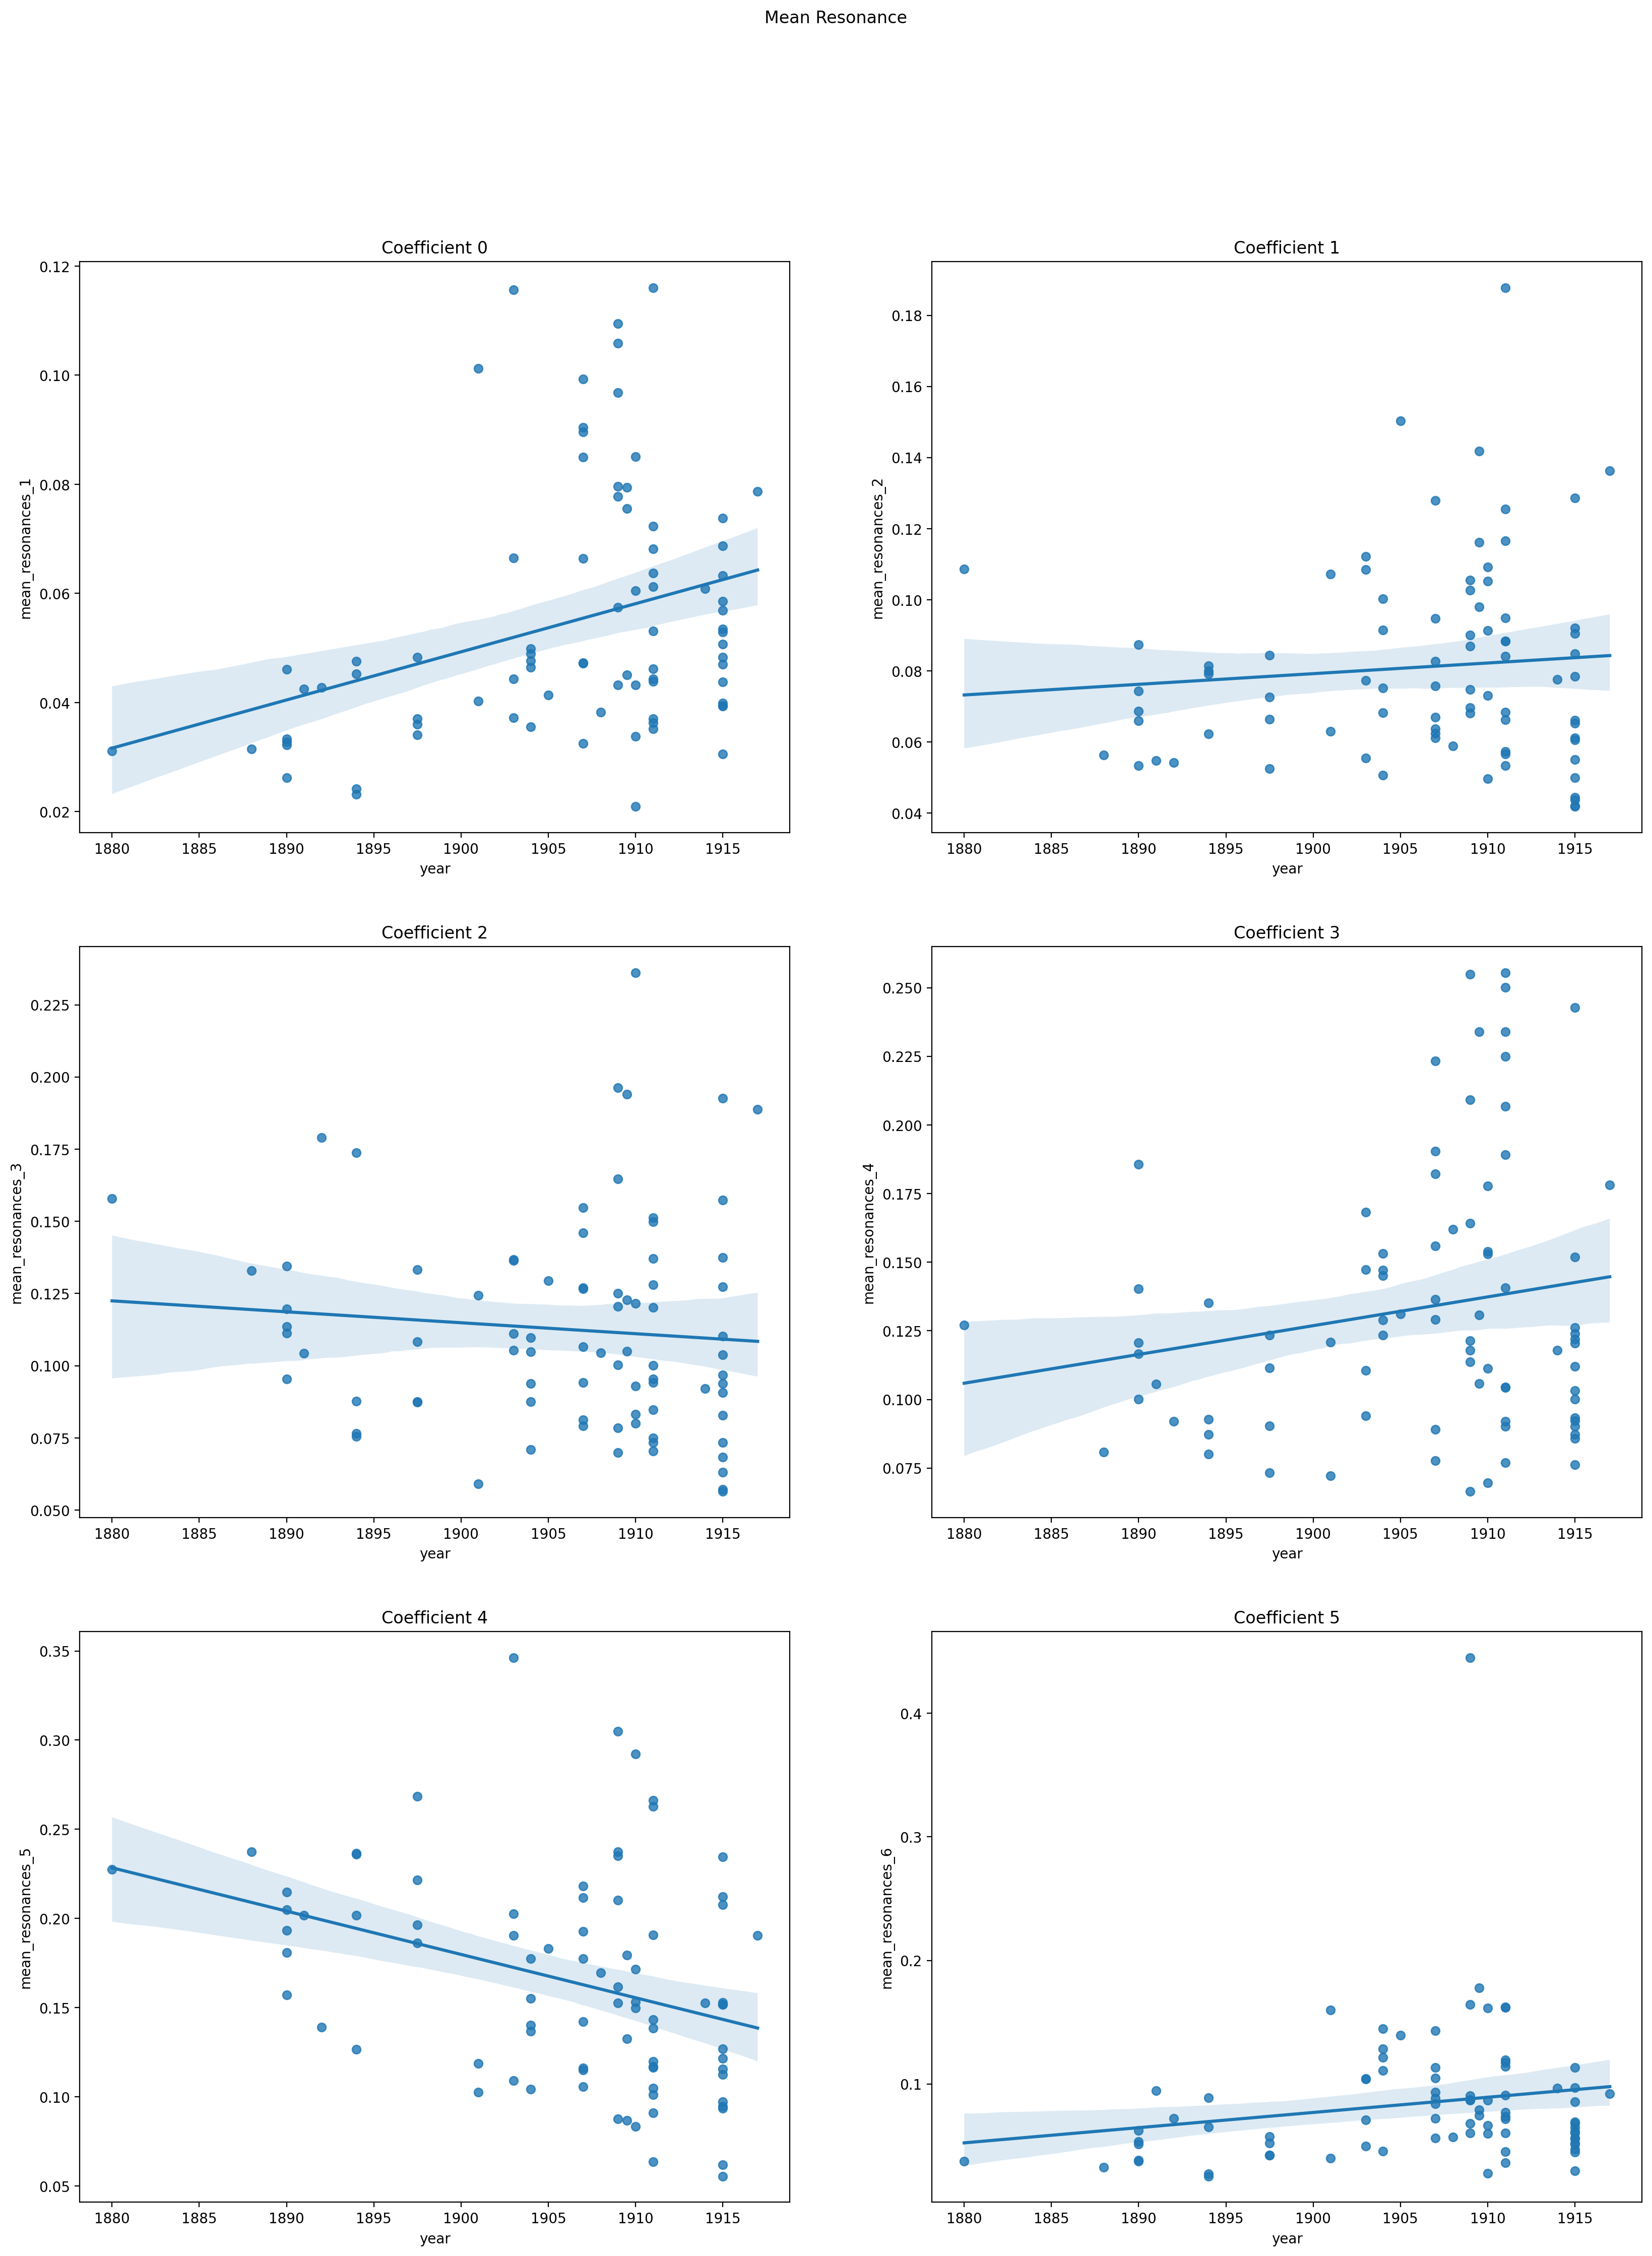

In [21]:
cols = [f"mean_resonances_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('mean_resonance', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='mean_resonances', title='Mean Resonance')
metadata_metrics.head(1)

In [22]:
# per period ordinal plot
metadata_metrics = etl.get_metric('mean_resonance', metadata_metrics, 
                              mag_phase_mx_dict=mag_phase_mx_dict,
                              cols=cols, store_matrix=True, 
                              show_plot=False, testing=True, save_name='mean_resonance_per_period', title='Mean Resonance per Period', boxplot=True,
                              ordinal=True, ordinal_col='years_periods')

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.05351475 0.06532752 0.10387982 0.15190818 0.15171844 0.06171801]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     33.80
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           2.29e-56
Time:                        21:04:16   Log-Likelihood:                 864.87
No. Observations:                 492   AIC:                            -1704.
Df Residuals:                     479   BIC:                            -1649.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
              

# Moment of Inertia

Moment of inertia of coefficient $n$ in the summary wavescape: $I(n)=1/N \sum_{i \in S(n)} w_i y_i^2$, where N is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient n is the most prominent among the six), $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, and $y_i$ is the vertical coordinate of the $i$-th node in the summary wavescape


6
Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [1.90162563e-08 3.43506222e-06 4.49260313e-03 6.56131004e-03
 3.25955897e-02 2.60217825e-05]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     21.37
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           9.54e-38
Time:                        21:04:17   Log-Likelihood:                 1314.1
No. Observations:                 492   AIC:                            -2602.
Df Residuals:                     479   BIC:                            -2548.
Df Model:                          12                                         
Covariance Type:            nonrobust                             

corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  mean_resonances_3  \
fname                                         ...                      
l000_etude               284.0        959.25  ...            0.10388   

            mean_resonances_4  mean_resonances_5  mean_resonances_6  \
fname                                                                 
l000_etude           0.151908           0.151718           0.061718   

            moments_of_inertia_1  moments_of_inertia_2  moments_of_inertia_3  \
fname                                                                          
l000_etude          1.901626e-08              0.000003              0.004493   

           moments_of_inertia_4 moments_of_inertia_5 moments_of_inertia_6  
fname                                                                      
l000_etude             0.006561             0.032596             0.000026  

[1 rows x 90 columns]

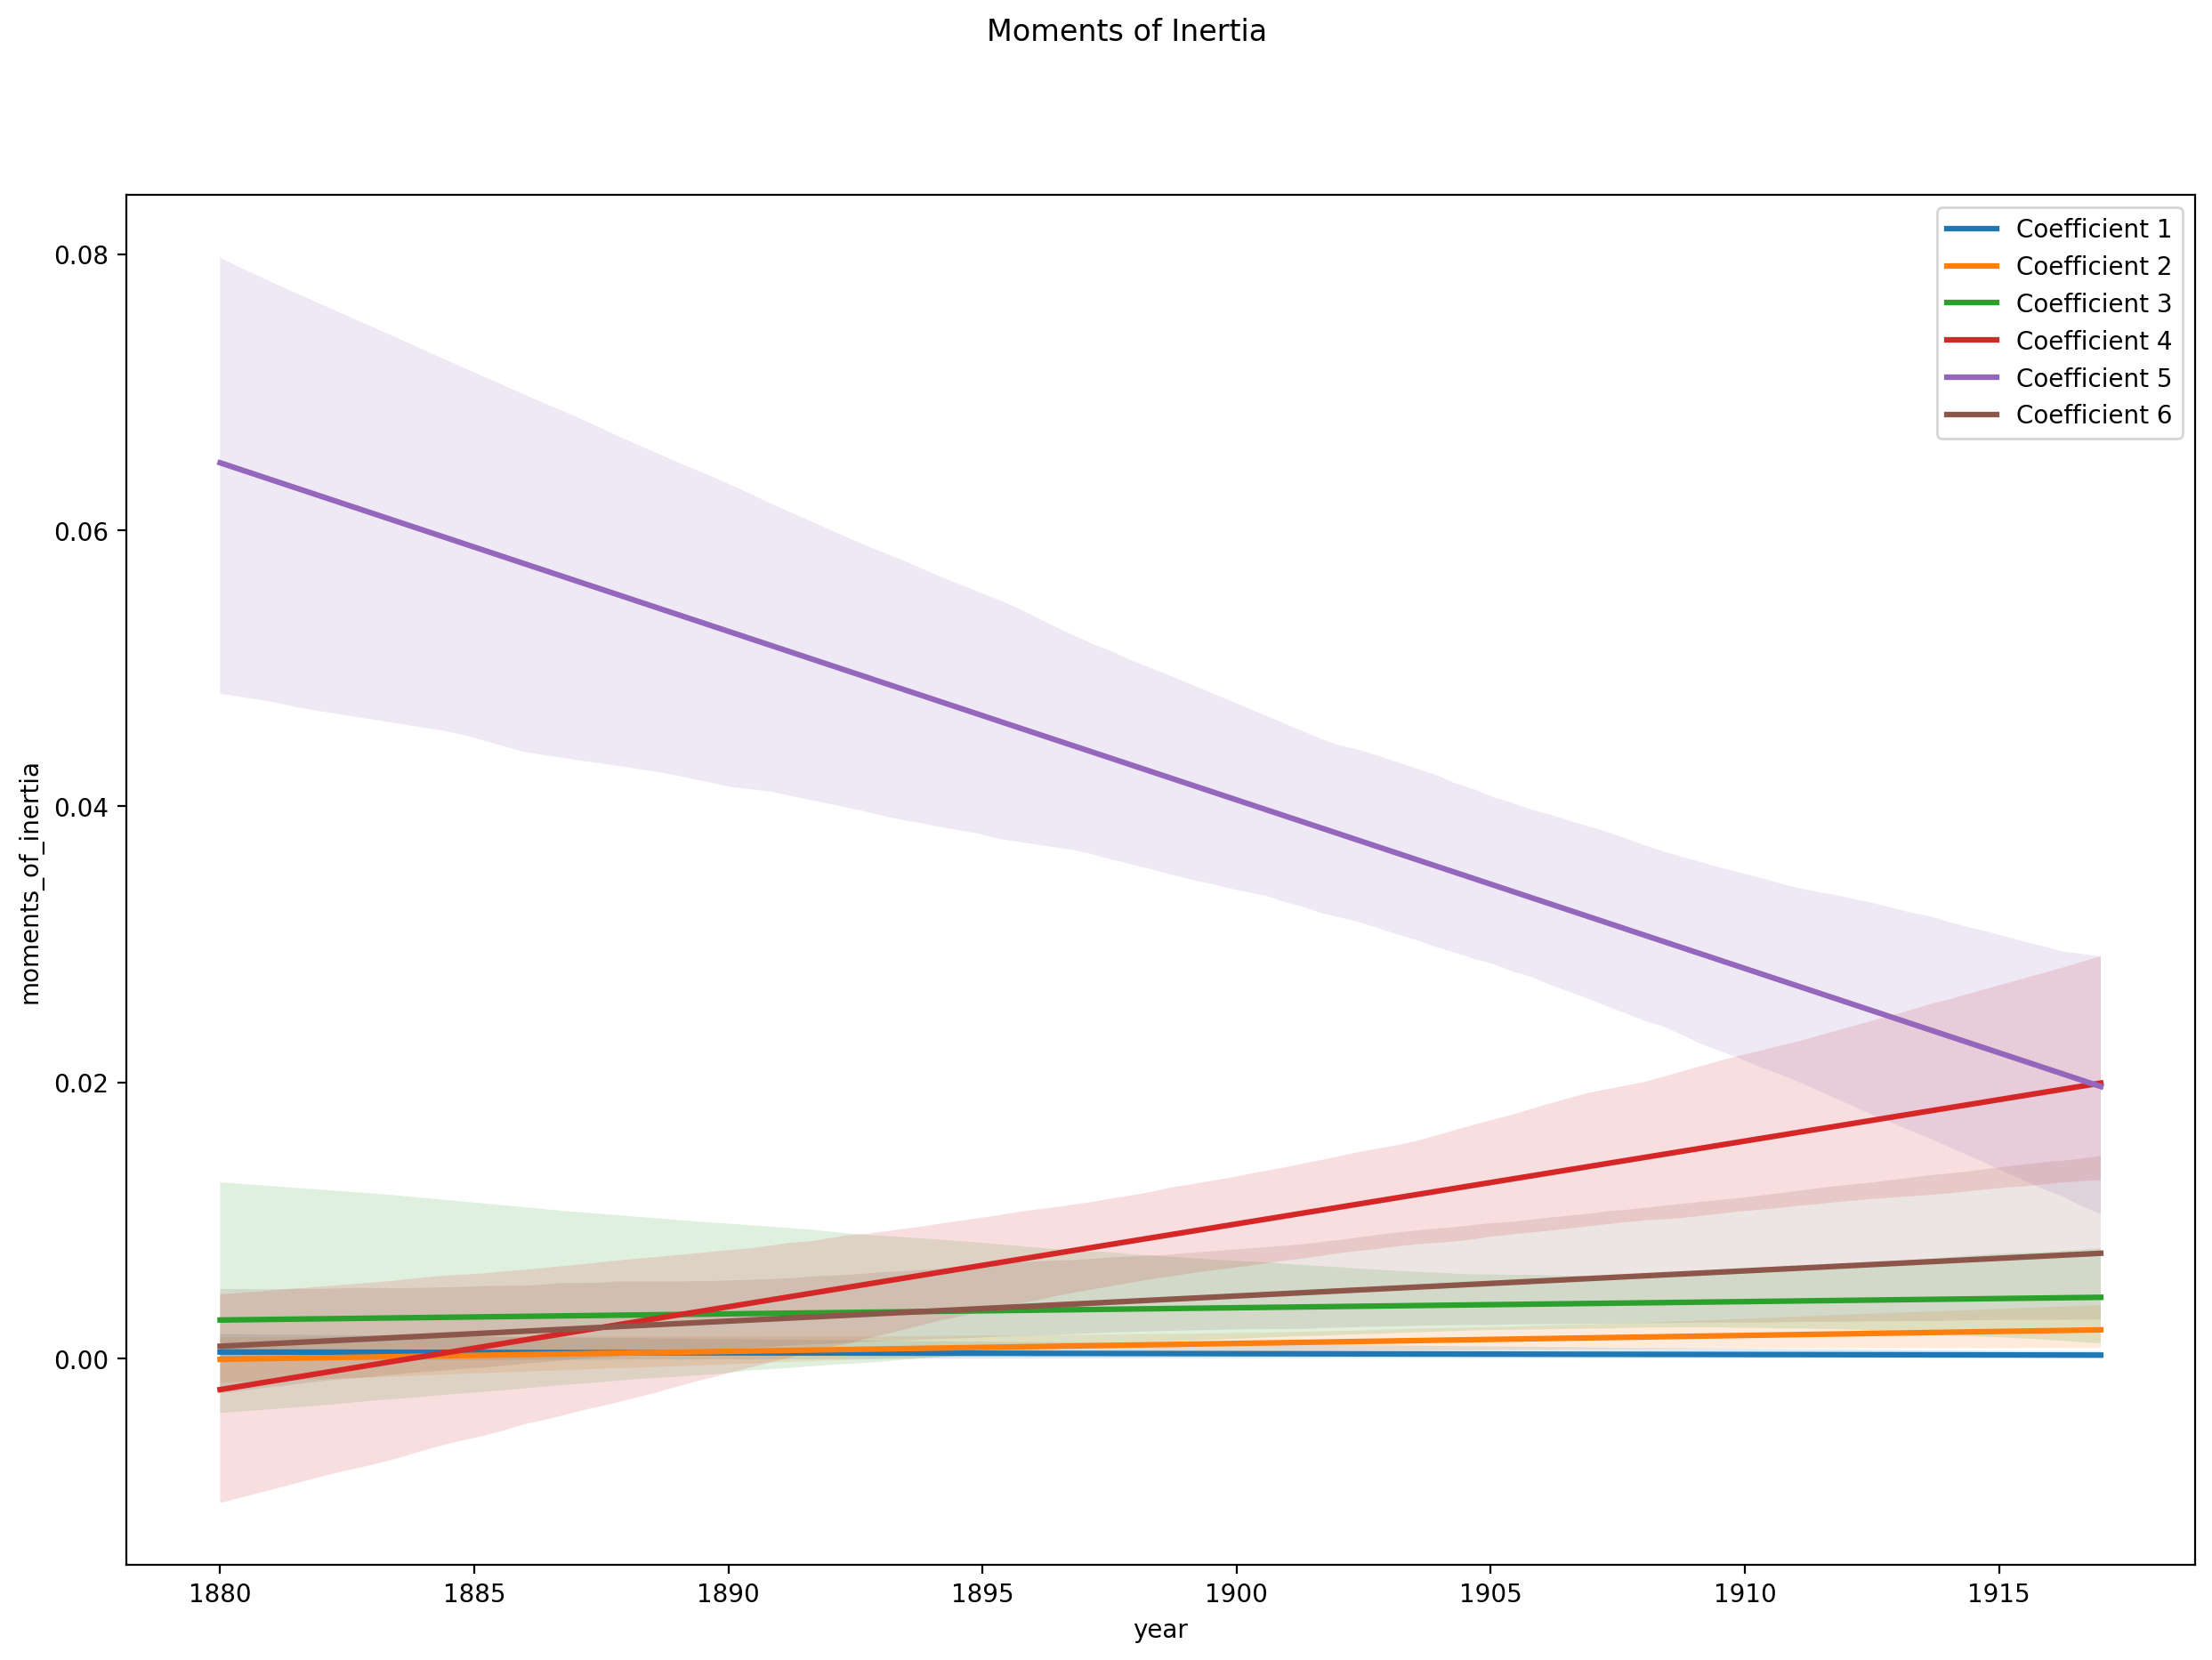

In [23]:
cols = [f"moments_of_inertia_{i}" for i in range(1,7)]
print(len(cols))
metadata_metrics = etl.get_metric('moment_of_inertia', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              max_mags=max_mags,
                              cols=cols, store_matrix=True,
                              testing=True, 
                              show_plot=True, save_name='moments_of_inertia', title='Moments of Inertia', unified=True)
metadata_metrics.head(1)

# Prevalence of each coefficient

Prevalence of coefficient $n$ in a piece: $W(n)=1/N \sum_{i \in S(n)} i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six).

Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [0.99692521 0.00203333 0.15572307 0.32240627 0.51894465 0.00396747]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     149.3
Date:                Tue, 06 Jun 2023   Prob (F-statistic):          2.92e-153
Time:                        21:04:38   Log-Likelihood:                 155.00
No. Observations:                 492   AIC:                            -284.0
Df Residuals:                     479   BIC:                            -229.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
              

corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  moments_of_inertia_3  \
fname                                         ...                         
l000_etude               284.0        959.25  ...              0.004493   

            moments_of_inertia_4  moments_of_inertia_5  moments_of_inertia_6  \
fname                                                                          
l000_etude              0.006561              0.032596              0.000026   

            percentage_resonances_1  percentage_resonances_2  \
fname                                                          
l000_etude                 0.996925                 0.002033   

            percentage_resonances_3 percentage_resonances_4  \
fname                                                         
l000_etude                 0.155723                0.322406   

           percentage_resonances_5 percentage_resonances_6  
fname                                                       
l000_etude                0.518945                0.003967  

[1 rows x 96 columns]

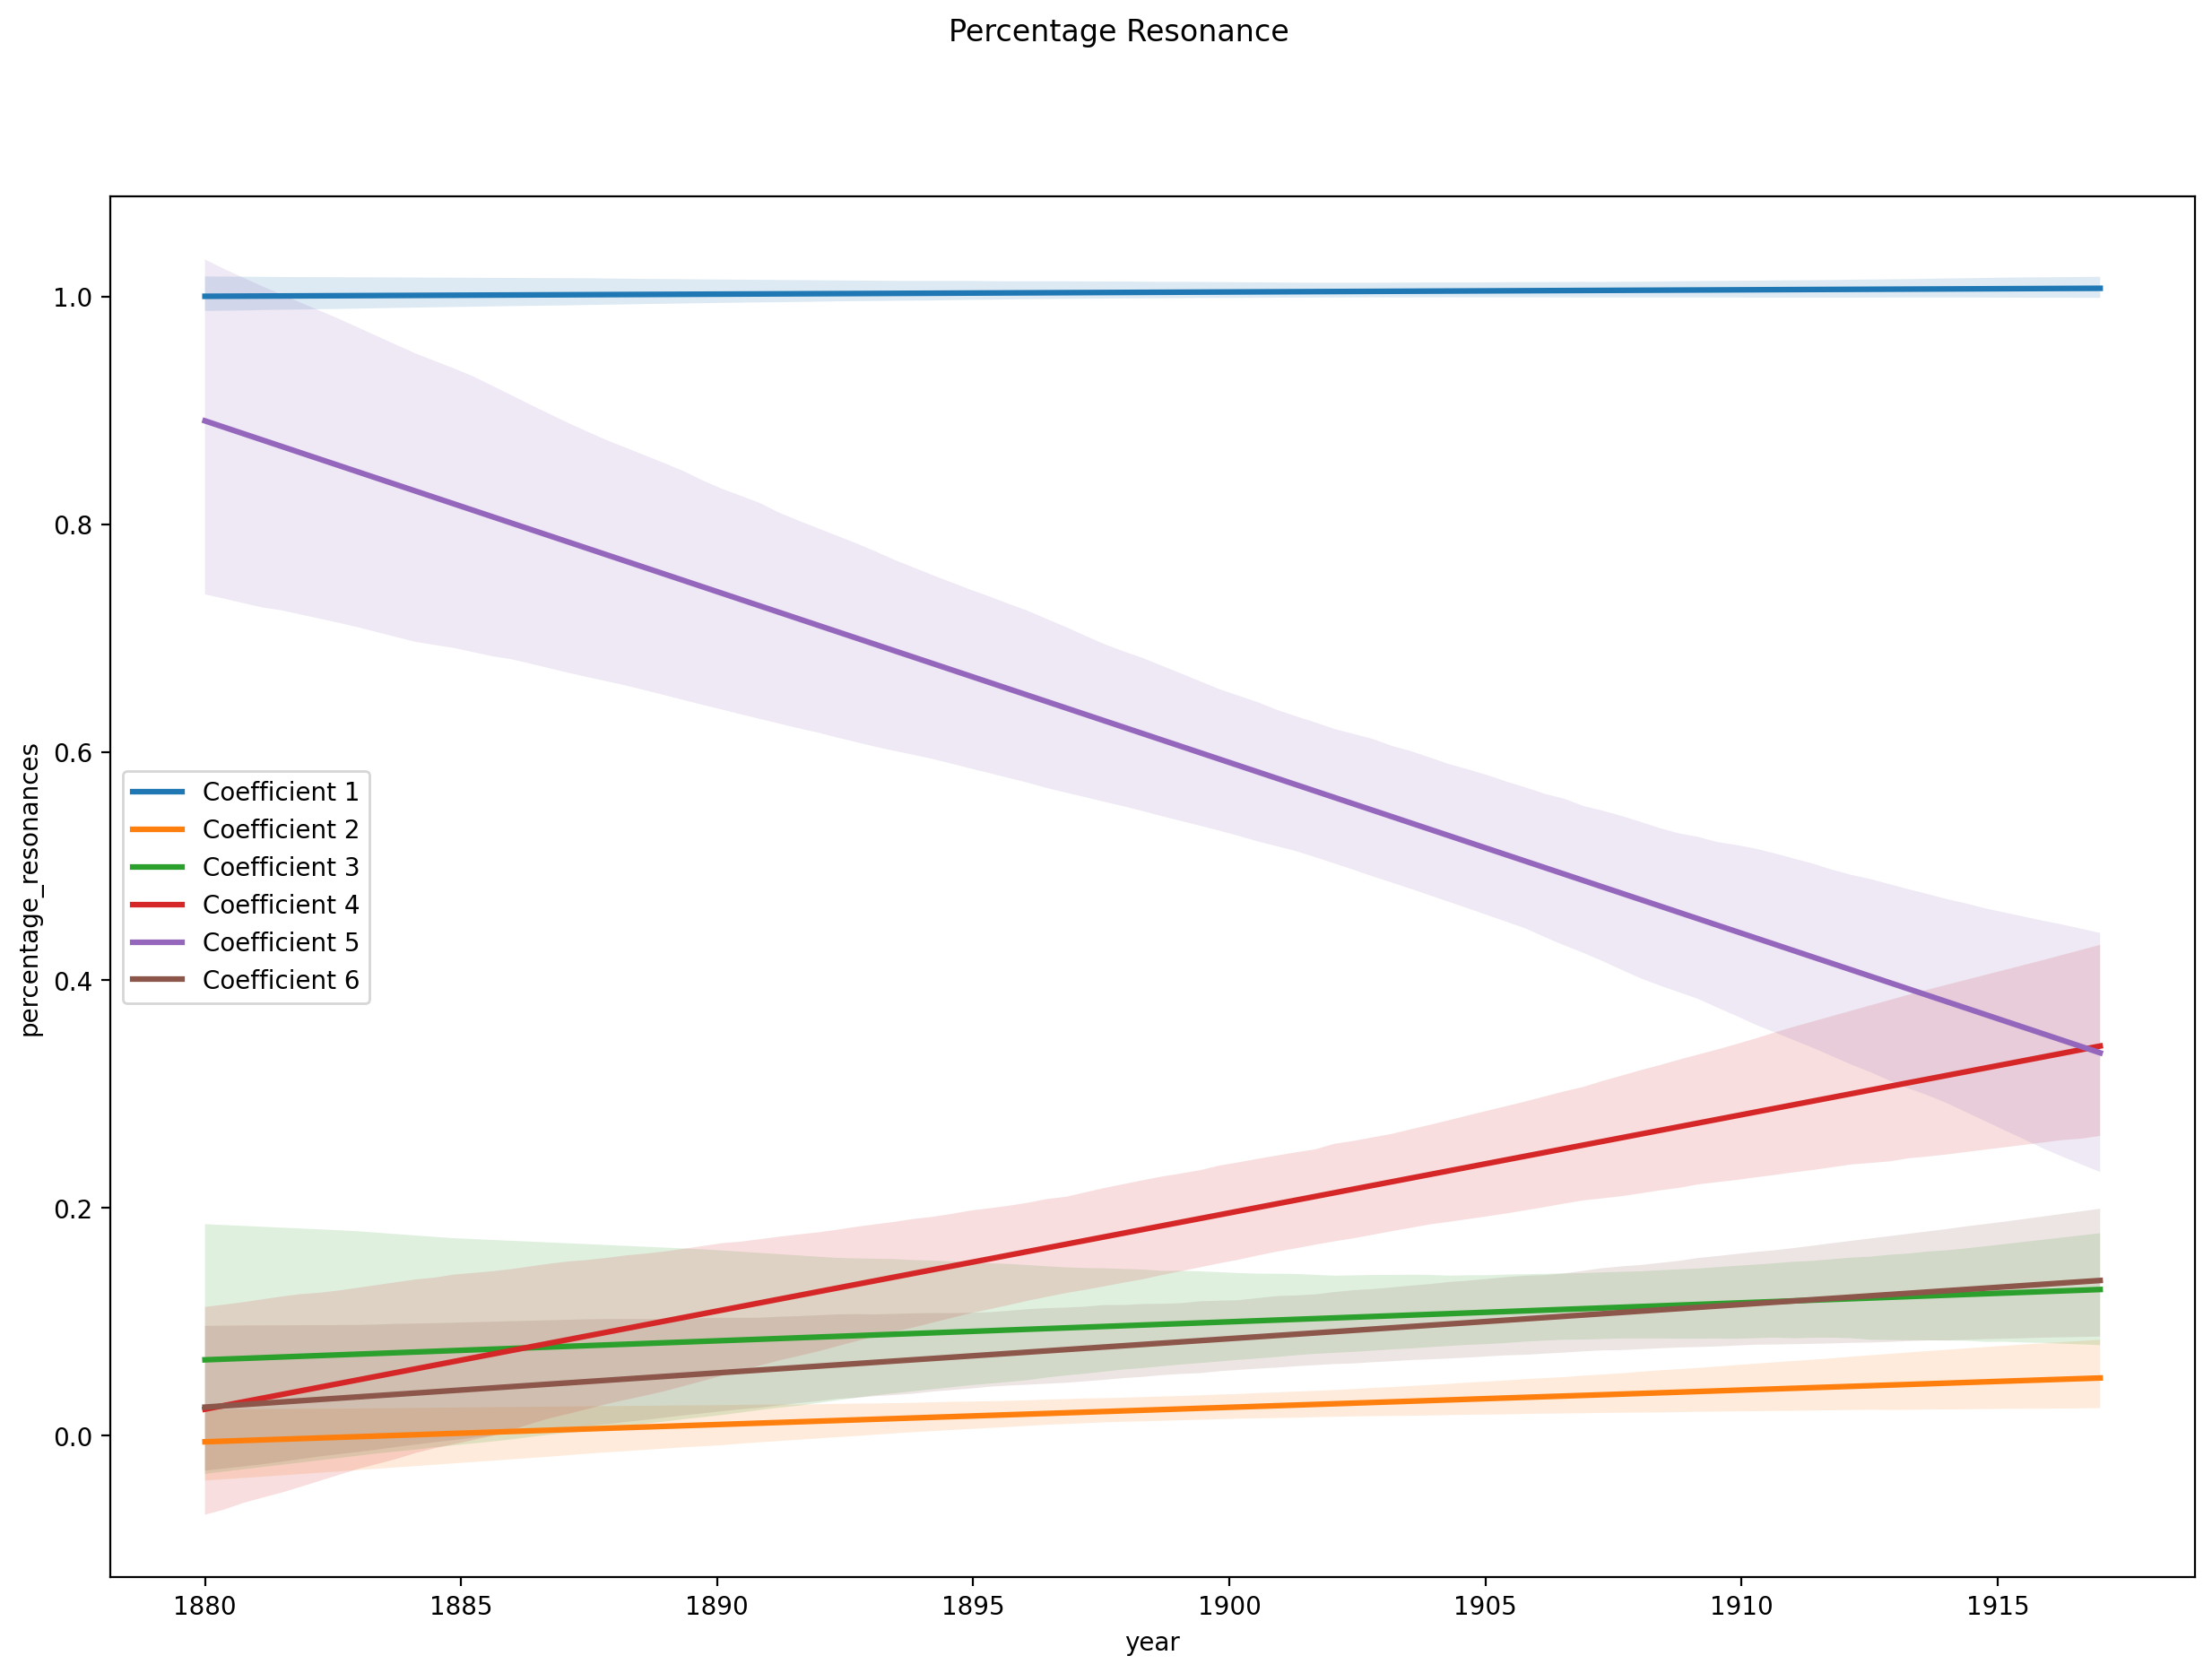

In [25]:
cols = [f"percentage_resonances_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('percentage_resonance', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              cols=cols, store_matrix=True, testing=True,
                              show_plot=True, save_name='percentage_resonance', title='Percentage Resonance', unified=True)
metadata_metrics.head(1)

In [26]:
# metadata_metrics = get_metric('percentage_resonance', metadata_metrics, 
#                               max_coeffs=max_coeffs,
#                               cols=cols, store_matrix=True, 
#                               show_plot=True, save_name='percentage_resonance_periods', title='Percentage Resonance (Periods)',  boxplot=True,
#                               ordinal=True, ordinal_col='years_periods')

In order to account for the certainty that a certain coefficient is actually the most resonance, we weigh the previous metric by entropy as follows: $W(n)=1/N \sum_{i \in S(n)} w_i$ where $N$ is the total number of nodes in the wavescape, $S(n)$ is the set of the indices of the nodes in the summary wavescapes that are attributed to coefficient $n$ (i.e., where coefficient $n$ is the most prominent among the six), and $w_i$ is the weight (opacity) of the $i$-th node in the summary wavescape, in this case, the entropy of $i$.



Found matrices for all files listed in metadata.tsv.
The example center of mass list has len 6.
Example results [3.67541420e-05 3.37187982e-04 3.62324310e-02 7.44987551e-02
 1.13180661e-01 5.87240293e-04]
testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     27.59
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           1.81e-47
Time:                        21:04:40   Log-Likelihood:                 667.69
No. Observations:                 492   AIC:                            -1309.
Df Residuals:                     479   BIC:                            -1255.
Df Model:                          12                                         
Covariance Type:            nonrobust                               

corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  percentage_resonances_3  \
fname                                         ...                            
l000_etude               284.0        959.25  ...                 0.155723   

            percentage_resonances_4  percentage_resonances_5  \
fname                                                          
l000_etude                 0.322406                 0.518945   

            percentage_resonances_6  percentage_resonances_entropy_1  \
fname                                                                  
l000_etude                 0.003967                         0.000037   

            percentage_resonances_entropy_2  percentage_resonances_entropy_3  \
fname                                                                          
l000_etude                         0.000337                         0.036232   

           percentage_resonances_entropy_4 percentage_resonances_entropy_5  \
fname                                                                        
l000_etude                        0.074499                        0.113181   

           percentage_resonances_entropy_6  
fname                                       
l000_etude                        0.000587  

[1 rows x 102 columns]

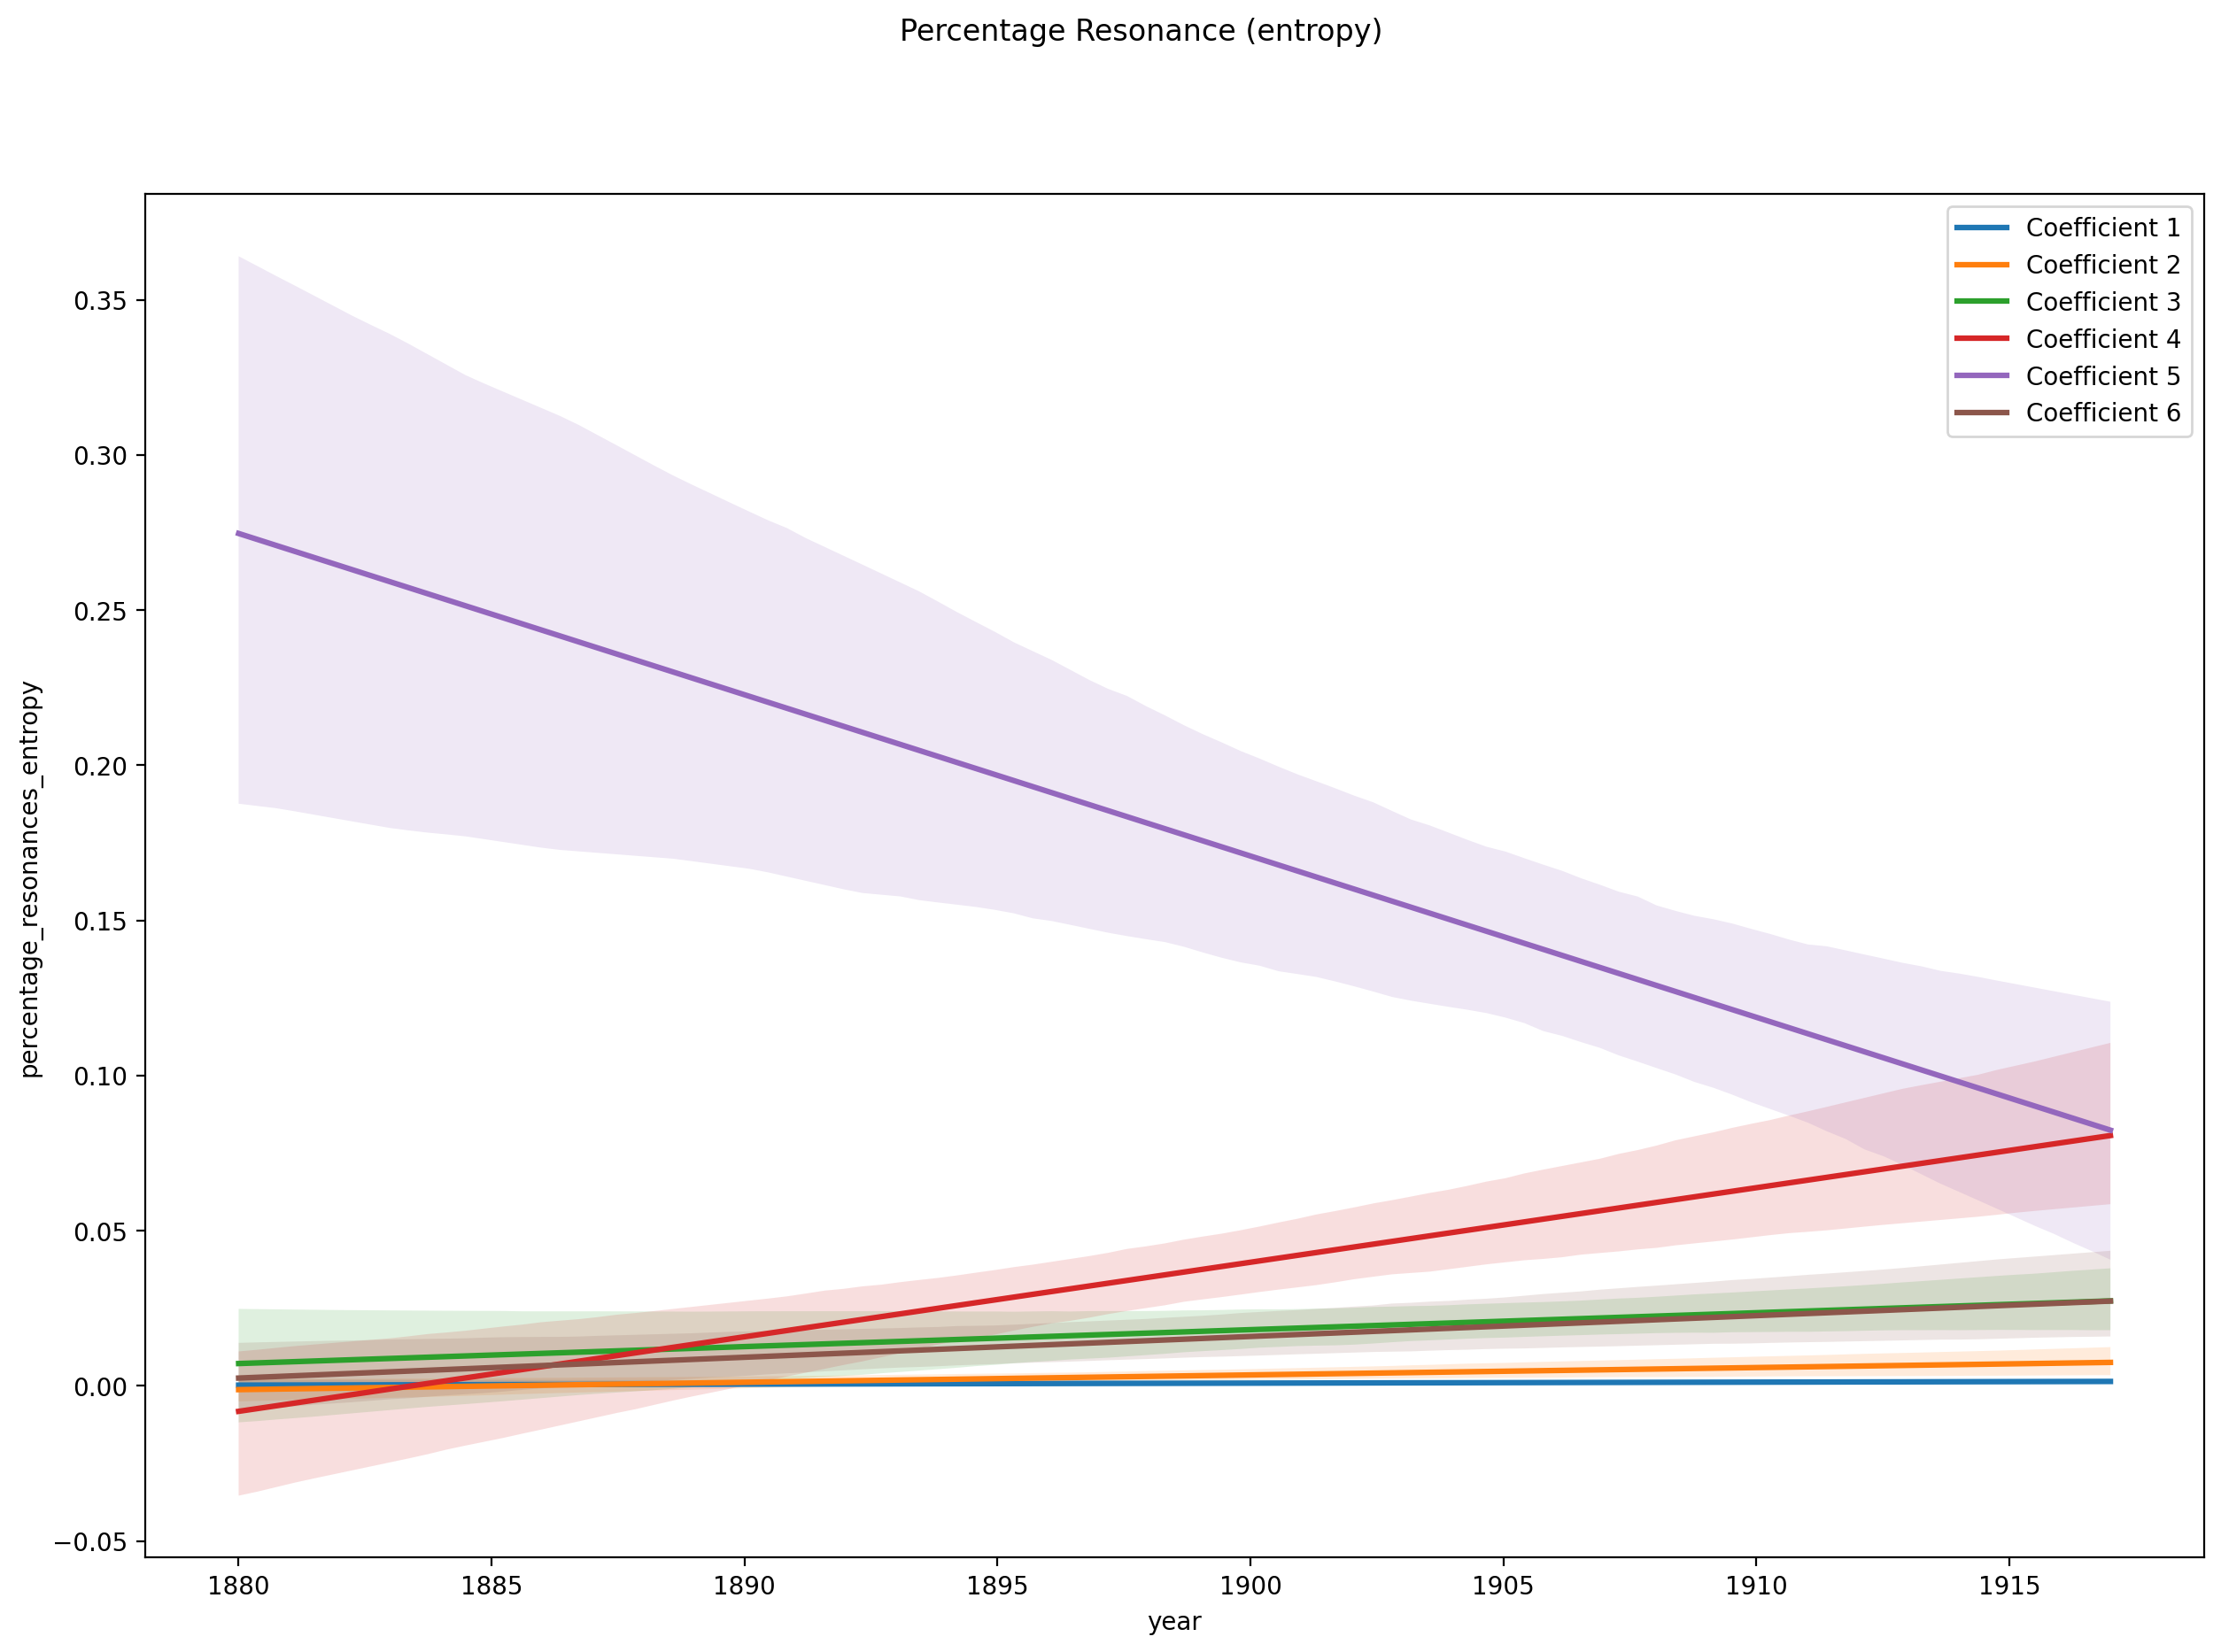

In [27]:
cols = [f"percentage_resonances_entropy_{i}" for i in range(1,7)]

metadata_metrics = etl.get_metric('percentage_resonance_entropy', metadata_metrics, 
                              max_coeffs=max_coeffs,
                              inv_entropies=inv_entropies,
                              cols=cols, store_matrix=True, 
                              testing=True,
                              show_plot=True, save_name='percentage_resonance_entropy', title='Percentage Resonance (entropy)', unified=True)
metadata_metrics.head(1)

# Decreasing magnitude in height

The inverse coherence is the slope of the regression line that starts from the magnitude resonance in the summary wavescape at bottom of the wavescape and reaches the one at the top of the wavescape.

corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  percentage_resonances_5  \
fname                                         ...                            
l000_etude               284.0        959.25  ...                 0.518945   

            percentage_resonances_6  percentage_resonances_entropy_1  \
fname                                                                  
l000_etude                 0.003967                         0.000037   

            percentage_resonances_entropy_2  percentage_resonances_entropy_3  \
fname                                                                          
l000_etude                         0.000337                         0.036232   

            percentage_resonances_entropy_4  percentage_resonances_entropy_5  \
fname                                                                          
l000_etude                         0.074499                         0.113181   

           percentage_resonances_entropy_6 partition_entropy inverse_coherence  
fname                                                                           
l000_etude                        0.000587          0.130534         -0.332186  

[1 rows x 104 columns]

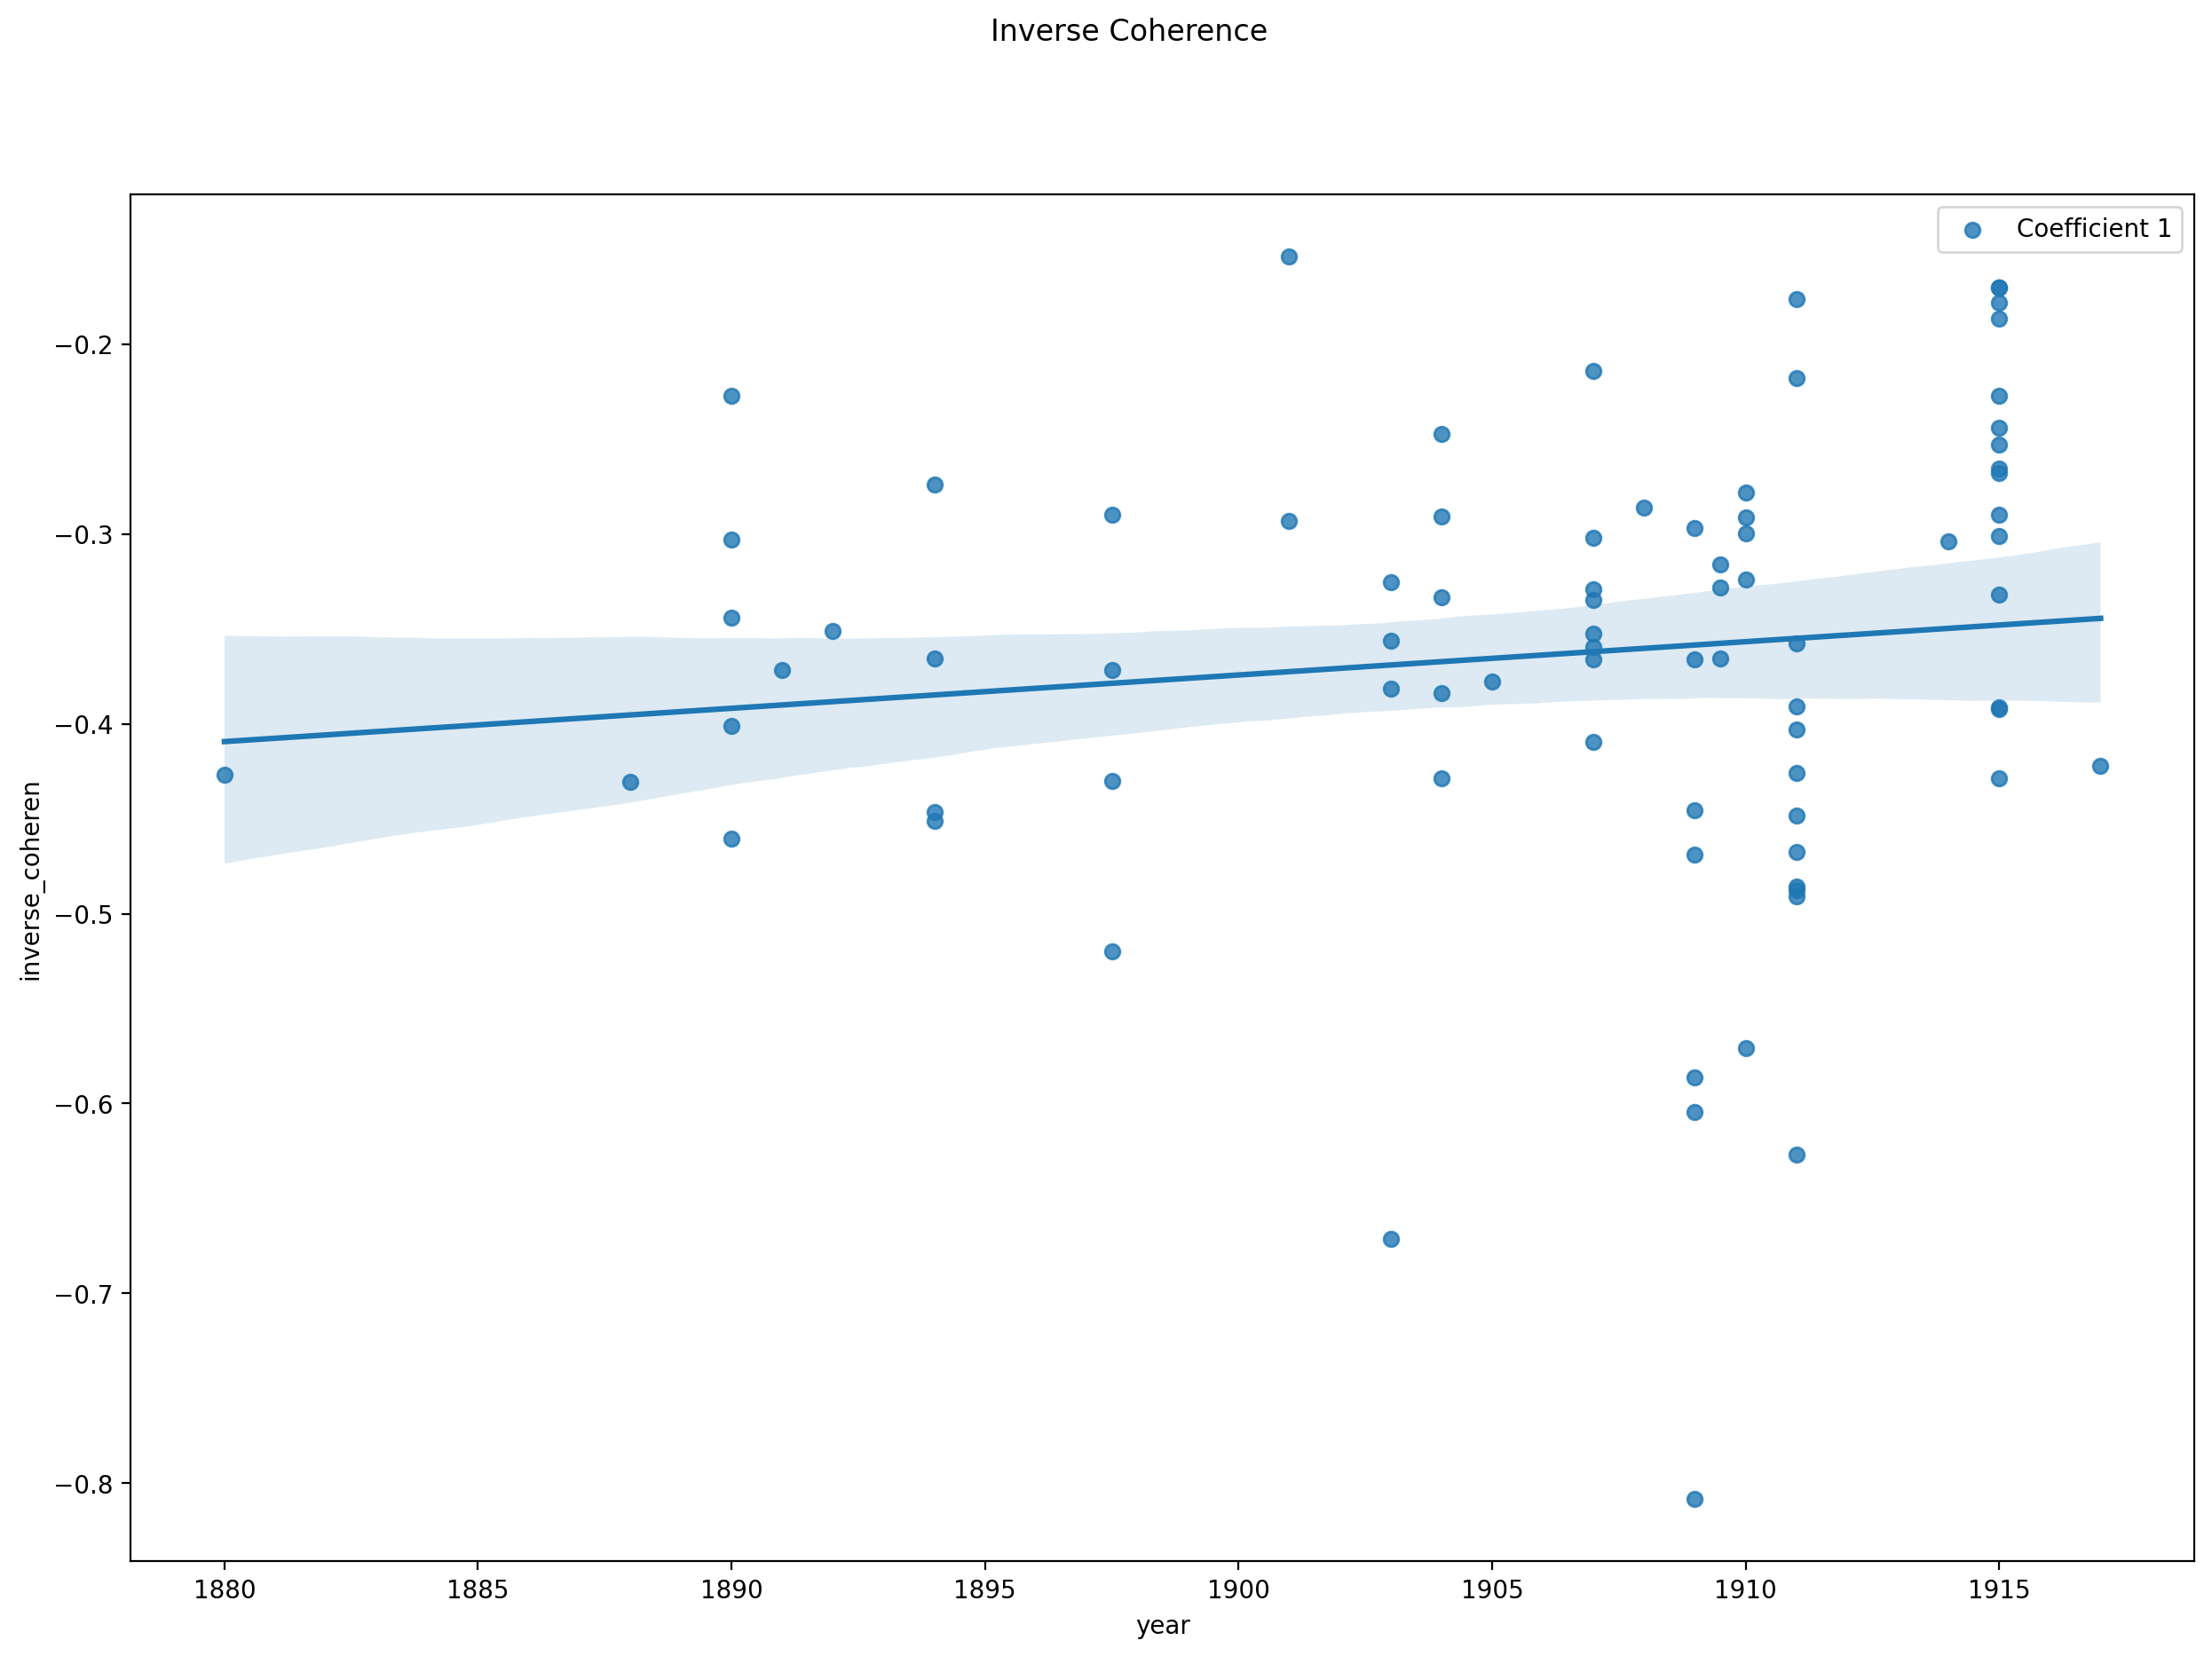

In [35]:
cols = 'inverse_coherence'
metadata_metrics = etl.get_metric('inverse_coherence', metadata_metrics, 
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, 
                              show_plot=True, save_name='inverse_coherence', title='Inverse Coherence', unified=True, scatter=True)
metadata_metrics.head(1)

In [36]:
metadata_metrics.head(1)

corpus TimeSig  \
fname                                            
l000_etude  debussy_other_piano_pieces  1: 4/4   

                                                       KeySig  last_mc  \
fname                                                                    
l000_etude  1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...       73   

            last_mn  length_qb  last_mc_unfolded  last_mn_unfolded  \
fname                                                                
l000_etude       71      284.0                73                71   

            length_qb_unfolded  all_notes_qb  ...  percentage_resonances_5  \
fname                                         ...                            
l000_etude               284.0        959.25  ...                 0.518945   

            percentage_resonances_6  percentage_resonances_entropy_1  \
fname                                                                  
l000_etude                 0.003967                         0.000037   

            percentage_resonances_entropy_2  percentage_resonances_entropy_3  \
fname                                                                          
l000_etude                         0.000337                         0.036232   

            percentage_resonances_entropy_4  percentage_resonances_entropy_5  \
fname                                                                          
l000_etude                         0.074499                         0.113181   

           percentage_resonances_entropy_6 partition_entropy inverse_coherence  
fname                                                                           
l000_etude                        0.000587          0.130534         -0.332186  

[1 rows x 104 columns]

In [37]:
metadata_metrics.to_csv('results/results.csv')

In [38]:
metadata_metrics.sort_values('inverse_coherence').tail()

corpus  \
fname                                           
l136-06_etudes_huit            debussy_etudes   
l123-12_preludes_feux        debussy_preludes   
l136-09_etudes_notes           debussy_etudes   
l136-05_etudes_octaves         debussy_etudes   
l095-03_pour_toccata    debussy_pour_le_piano   

                                                                  TimeSig  \
fname                                                                       
l136-06_etudes_huit     1: 3/4, 2: 2/4, 4: 3/4, 5: 2/4, 43: 3/4, 44: 2...   
l123-12_preludes_feux   1: 4/8, 30: 2/8, 31: 4/8, 32: 3/8, 33: 4/8, 38...   
l136-09_etudes_notes                                               1: 4/4   
l136-05_etudes_octaves                                             1: 3/8   
l095-03_pour_toccata                                               1: 2/4   

                                                                   KeySig  \
fname                                                                       
l136-06_etudes_huit                          1: -6, 13: -3, 29: 0, 33: -6   
l123-12_preludes_feux   1: -1, 41: -5, 47: 0, 57: 3, 61: 0, 65: 6, 68:...   
l136-09_etudes_notes              1: 1, 28: 0, 50: 1, 59: 4, 63: 0, 67: 1   
l136-05_etudes_octaves  1: 4, 11: 0, 13: 4, 15: 0, 21: 4, 23: -3, 29: ...   
l095-03_pour_toccata                  1: 4, 78: 0, 198: 7, 206: 4, 228: 7   

                        last_mc  last_mn  length_qb  last_mc_unfolded  \
fname                                                                   
l136-06_etudes_huit          69       68     146.00                69   
l123-12_preludes_feux       100      100     206.25               100   
l136-09_etudes_notes         85       84     336.00                85   
l136-05_etudes_octaves      121      121     181.50               121   
l095-03_pour_toccata        266      266     532.00               266   

                        last_mn_unfolded  length_qb_unfolded  all_notes_qb  \
fname                                                                        
l136-06_etudes_huit                   68              146.00        175.25   
l123-12_preludes_feux                100              206.25        515.73   
l136-09_etudes_notes                  84              336.00        734.62   
l136-05_etudes_octaves               121              181.50        595.83   
l095-03_pour_toccata                 266              532.00       1650.75   

                        ...  percentage_resonances_5  percentage_resonances_6  \
fname                   ...                                                     
l136-06_etudes_huit     ...                 0.400380                 0.010939   
l123-12_preludes_feux   ...                 0.042308                 0.208828   
l136-09_etudes_notes    ...                 0.024926                 0.189270   
l136-05_etudes_octaves  ...                 0.400904                 0.015750   
l095-03_pour_toccata    ...                 0.562645                 0.029742   

                        percentage_resonances_entropy_1  \
fname                                                     
l136-06_etudes_huit                            0.007745   
l123-12_preludes_feux                          0.008693   
l136-09_etudes_notes                           0.000427   
l136-05_etudes_octaves                         0.000242   
l095-03_pour_toccata                           0.001327   

                        percentage_resonances_entropy_2  \
fname                                                     
l136-06_etudes_huit                            0.000239   
l123-12_preludes_feux                          0.032550   
l136-09_etudes_notes                           0.040101   
l136-05_etudes_octaves                         0.000187   
l095-03_pour_toccata                           0.011945   

                        percentage_resonances_entropy_3  \
fname                                                     
l136-06_etudes_huit                       

In [39]:
max_mag = max_mags[EXAMPLE_FNAME]
#max_coeff = max_coeffs['l108_morceau']
np.polyfit((max_mag.shape[1] - np.arange(max_mag.shape[1]))/max_mag.shape[1], np.mean(max_mag, axis=0), 1)[0]

-0.6268334619608593

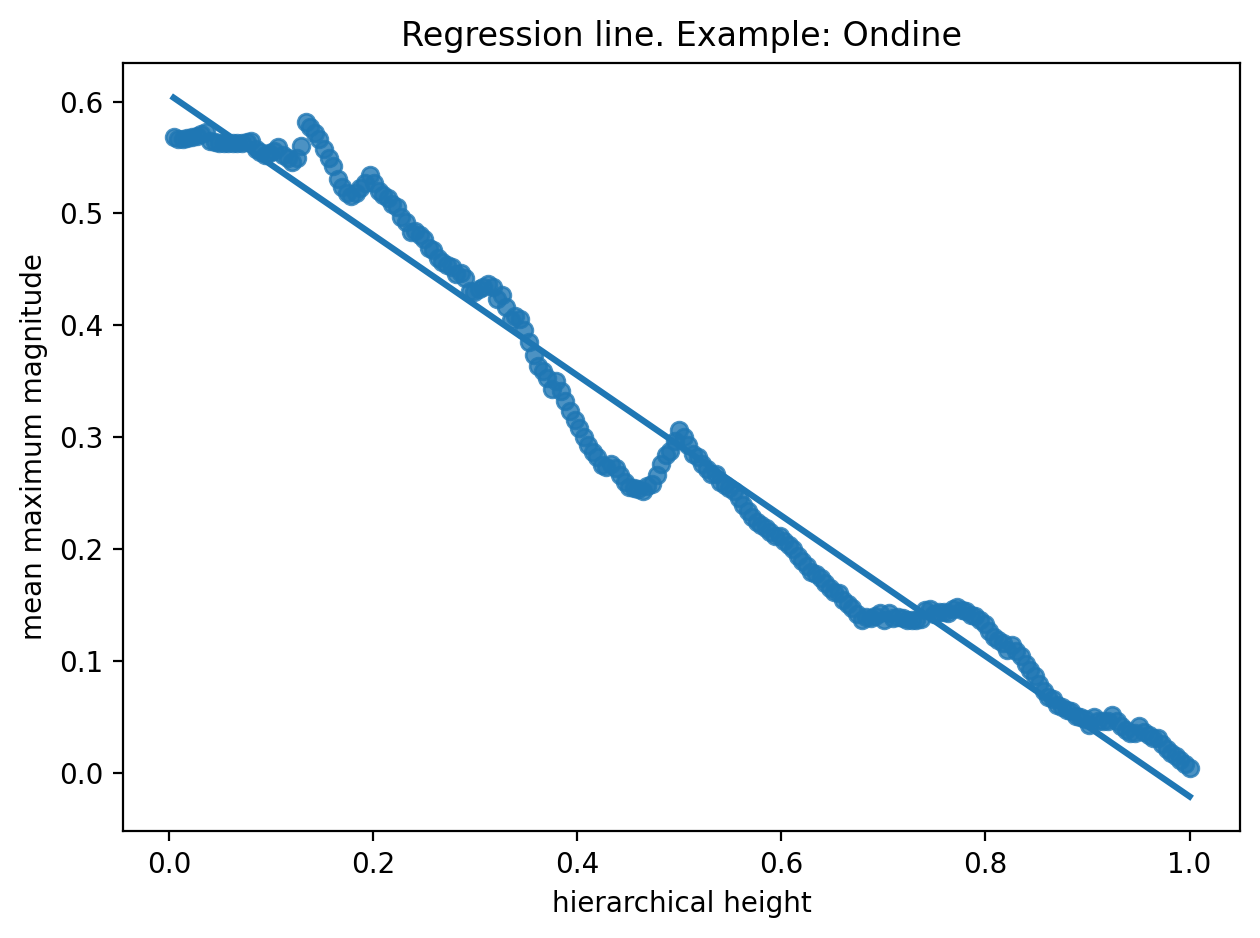

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.regplot(x=(max_mag.shape[1] - np.arange(max_mag.shape[1]))/max_mag.shape[1], y=np.mean(max_mag, axis=0), ci=False)
ax.set_title('Regression line. Example: Ondine')
ax.set_xlabel('hierarchical height')
ax.set_ylabel('mean maximum magnitude')

plt.tight_layout()
plt.savefig('figures/coherence.png')

plt.show()

In [42]:
metadata_metrics = etl.get_metric('inverse_coherence', metadata_metrics, 
                              max_mags=max_mags,
                              cols=cols, store_matrix=True, 
                              show_plot=False, testing=True)

testing results
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.364
Date:                Tue, 06 Jun 2023   Prob (F-statistic):            0.00654
Time:                        21:24:48   Log-Likelihood:                -111.13
No. Observations:                  82   AIC:                             228.3
Df Residuals:                      79   BIC:                             235.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -53.3907     25.739    

Storing the final metrics for future use:

In [43]:
metadata_metrics.reset_index().to_csv('normalized_coherence.csv')

In [44]:
metadata_metrics.reset_index().to_csv('metrics_new.csv')